In [1]:
import importlib
from numpy.core.numeric import Inf
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from NNet.utils.writeNNet import writeNNet
import matplotlib.pyplot as plt
import models
import datasets
import pandas as pd
import matplotlib.patches as patches

In [2]:
import importlib

In [3]:
importlib.reload(datasets)

<module 'datasets' from '/home/wth/dev/ouroboros/src/datasets.py'>

In [4]:
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main
Main.include("verify.jl")

<PyCall.jlwrap sample_counter_examples>

In [5]:
def train(dataloader, model, loss_fn, optimizer, device, acc_cnt_fn, verbose=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        correct += acc_cnt_fn(pred, y)
        if verbose and batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct = correct * 1. / size
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    return correct, train_loss

def test(dataloader, model, loss_fn, device, acc_cnt_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    digit_size, digit_correct = 0, 0
    positive = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += acc_cnt_fn(pred, y)
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#             correct += (((pred > 0) != y).sum(axis=-1) == 0).sum()
#             digit_correct += (((pred > 0) == y).sum(axis=-1)).sum()
#             positive += (y > 0).sum().item()
#             digit_size += y.shape[0] * y.shape[1]
    test_loss /= num_batches
    correct = correct * 1. / size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
#     digit_correct = digit_correct * 1. / digit_size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Digit Accuracy: {(100*digit_correct):>0.1f}%, Positive: {(positive*100./size):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

def plot_acc_loss(accs, losses, verify_steps):
    plt.figure()
    plt.plot(accs, label="accuracy")
    plt.axvline(x = -100, c='g', linestyle=":", label = 'verified safe')
    plt.axvline(x = -100, c='r', linestyle=":", label = 'found counter examples')
    for t in verify_steps:
        plt.axvline(x=t[0], c='g' if t[1] else 'r', linestyle=":")
    plt.xlim([0,len(accs)+1])
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(losses, label="loss")
    plt.axvline(x = -100, c='g', linestyle=":", label = 'verified safe')
    plt.axvline(x = -100, c='r', linestyle=":", label = 'found counter examples')
    for t in verify_steps:
        plt.axvline(x=t[0], c='g' if t[1] else 'r', linestyle=":")
    plt.xlim([0,len(accs)+1])
    plt.legend()
    plt.show()
    
def save_nnet(model, save_name):
    weights = []
    biases = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights.append(param.cpu().detach().numpy())
        if 'bias' in name:
            biases.append(param.cpu().detach().numpy())
    
    _ = np.zeros(weights[0].shape[1]+1)
    writeNNet(weights, biases, _, _, _, _, save_name)



In [6]:
def train_and_verify(task):
    
    task.training_data_spec_check()
    
    print("Using {} device".format(task.device))

    # Create data loaders.
    train_dataloader = DataLoader(task.training_data, batch_size=task.batch_size)
    test_dataloader = DataLoader(task.testing_data, batch_size=task.batch_size)

    accs = []
    losses = []
    verified_steps = []
    
    for t in range(task.epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        
        if t == task.start_finetune_epoch:
            task.start_finetune()
        
        acc, loss = train(train_dataloader, task.model, task.loss_fn, task.optimizer, task.device, task.acc_cnt_fn)
        accs.append(acc)
        losses.append(loss)
        
        if task.start_verify(acc, loss):
            print("start verifying")
            nnet_path = task.save_prefix + str(t) + ".nnet"
            save_nnet(task.model, nnet_path)
            
            results = task.check_specs(nnet_path)
            
            train_dataloader = DataLoader(task.training_data, batch_size=task.batch_size)
            test_dataloader = DataLoader(task.testing_data, batch_size=task.batch_size)
            print("len(task.training_data) = ", len(task.training_data))
            print("len(task.testing_data) = ", len(task.testing_data))
            acc, loss = test(test_dataloader, task.model, task.loss_fn, task.device, task.acc_cnt_fn)
            
            verified_steps.append((t, np.all(results)))
            
            if task.is_finished(results, acc):
                break

    print("Done!")
    
    return accs, losses, verified_steps


In [7]:
class Task():
    def __init__(self):
        self.set_seed()
        
        self.training_data, self.testing_data = self.get_data()
        self.X_specs, self.Y_specs, self.free_dim_len = self.get_specs()
        self.model = self.get_model()
        
        self.set_learning_params()
    
    def set_seed(self):
        torch.manual_seed(1)
        
    def training_data_spec_check(self):
        train_dataloader = DataLoader(self.training_data, batch_size=1)
        violation = 0
        for X, y in train_dataloader:
            X = X.detach().cpu().numpy().transpose()
            y = y.detach().cpu().numpy().transpose()
            if self.training_data.y_is_class:
                y = self.training_data.to_one_hot(y[0])
            for j, (X_spec, Y_spec) in enumerate(zip(self.X_specs, self.Y_specs)):
                if np.all(X_spec[0] @ X < X_spec[1]):
                    if np.any(Y_spec[0] @ y >= Y_spec[1]):
                        violation += 1
        print("training data violation rate = ", violation / len(self.training_data))
        return violation

    def set_learning_params(self):
        self.save_prefix="../models/"
        self.device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"
        self.epochs = 1000
        self.batch_size = 1000
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.start_finetune_epoch = -1
        self.violated_spec_first = False
        self.max_verify_iter = 100
        self.counter_example_samling_size = 100
        
    def start_verify(self, acc, loss):
        return acc > 0.5
    
    def is_finished(self, results, acc):
        if np.all(results) and acc > 0.99:
            if self.free_dim_len >= 0.5:
                return True
            else:
                self.free_dim_len = min(self.free_dim_len * 2, 0.5)
                self.set_spec_free_dim_len()
        return False
    
    def start_finetune(self):
        print("Start finetuning.")
        for name, param in self.model.named_parameters():
            print(name, " ", "fc."+str(self.model.num_layer-1) in name)
            param.requires_grad = "fc."+str(self.model.num_layer-1) in name
    
    def check_specs(self, nnet_path):
        raise NotImplemented

    def acc_cnt_fn(self, pred, y):
        raise NotImplemented

    def get_model(self):
        raise NotImplemented
    
    def get_data(self):
        raise NotImplemented
        
    def get_specs(self):
        raise NotImplemented

    def get_label(self, x):
        raise NotImplemented

    def set_spec_free_dim_len(self):
        raise NotImplemented

In [10]:

class ClassificationTask(Task):
    def __init__(self):
        super().__init__()
        self.is_polytope_spec = True
    def acc_cnt_fn(self, pred, y):
        return (pred.argmax(1) == y).type(torch.float).sum().item()
    
    def check_specs(self, nnet_path):
        all_safe = True
        results = []
        spec_check_list_new = []
        if not self.violated_spec_first:
            self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
        for j, (X_spec, Y_spec) in enumerate(self.spec_check_list):
            status, counter_examples = Main.verify(nnet_path, X_spec, Y_spec, 
                                                   max_iter=self.max_verify_iter, 
                                                   sampling_size=self.counter_example_samling_size,
                                                   is_polytope=self.is_polytope_spec)
            print("verify result = ", status)
            results.append(status == "holds")
            if status == "holds":
                print("Verified safe for free_dim_len =", self.free_dim_len)
            elif status == "violated":
                print("adding counter example, num=", len(counter_examples))
                for counter_example in counter_examples:
                    pred = self.model(torch.from_numpy(counter_example).float().to(self.device))
                    pred_y = np.argmax(pred.detach().cpu().numpy())
                    gt_y = self.get_label(counter_example)
                    self.training_data.append(counter_example, gt_y)
                    self.testing_data = self.training_data
                spec_check_list_new.append((X_spec, Y_spec))
            elif status == "unknown":
                self.max_verify_iter *= 2
                spec_check_list_new.append((X_spec, Y_spec))

        print("checked spec count: ", len(self.spec_check_list))
        print("unsafe spec count: ", len(spec_check_list_new))

        if len(self.spec_check_list) != len(self.X_specs):
            results = results + [False] * (len(self.X_specs) - len(self.spec_check_list))
            
        if self.violated_spec_first:
            if len(spec_check_list_new) == 0:
                self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
            else:
                self.spec_check_list = spec_check_list_new

        return results

class ToyTask(ClassificationTask):
       
    def set_learning_params(self):
        self.save_prefix="../models/toy/"
        self.device = "cpu"
        self.epochs = 1000
        self.batch_size = 100
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.start_finetune_epoch = -1
        self.violated_spec_first = False
        self.max_verify_iter = 100
        self.counter_example_samling_size = 100
        
    def get_model(self):
        return models.FC(1, 3, 1000, 7)
    
    def get_data(self):
        normalize=True
        lifetime_class_bounds = [500, 1000, 10000, 10000, 100000, 1000000, Inf]
        data_path = '../data/allocator_generator/example_data/data_encoded.txt'
        training_data = datasets.allocator_dataset(data_path, lifetime_class_bounds, normalize=normalize)
        return training_data, training_data
    
    def get_specs(self):
        training_data = self.training_data
        normalize=True
        x_classes = [1,3,4,5]
        y_classes = [2,0,0,5]
        if normalize:
            x_classes = (x_classes-training_data.shift[1]) / training_data.scale[1]
        X_specs = []
        Y_specs = []
        free_dim_len = 0.5

        def equal_class(x_class, y_class, bd_eps=0.5, normalize=False):
            eps = 1e-3
            if normalize:
                X_spec = [np.array([
                    [ 1,0,0],
                    [-1,0,0],
                    [0, 1,0],
                    [0,-1,0],
                    [0,0, 1],
                    [0,0,-1],
                ]).astype(np.float), np.array([0.+bd_eps, -0.+bd_eps, x_class+eps, -x_class+eps, 0.+bd_eps, -0.+bd_eps])]
                Y_spec = [np.zeros((6,7)).astype(np.float), np.zeros(6).astype(np.float)]
                np.fill_diagonal(Y_spec[0], 1)
                Y_spec[0][:,y_class] = -1.
                Y_spec[0][y_class,6] = 1.
            else:
                X_spec = [np.array([
                    [ 1,0,0],
                    [-1,0,0],
                    [0, 1,0],
                    [0,-1,0],
                    [0,0, 1],
                    [0,0,-1],
                ]).astype(np.float), np.array([64.+bd_eps, -64.+bd_eps, x_class+eps, -x_class+eps, 2.+bd_eps, -2.+bd_eps])]
                Y_spec = [np.zeros((6,7)).astype(np.float), np.zeros(6).astype(np.float)]
                np.fill_diagonal(Y_spec[0], 1)
                Y_spec[0][:,y_class] = -1.
                Y_spec[0][y_class,6] = 1.
            return X_spec, Y_spec

        for i in range(4):
            X_spec, Y_spec = equal_class(x_classes[i], y_classes[i], bd_eps = free_dim_len, normalize=normalize)
            X_specs.append(X_spec)
            Y_specs.append(Y_spec)
        
        self.y_classes = y_classes
        return X_specs, Y_specs, free_dim_len
    
    def get_label(self, x):
        x_values = (np.array([1,3,4,5]) - 1) / 4
        x_class = np.argmin(np.abs(x_values - x[1]))
        y_classes = np.array([2,0,0,5])
        return y_classes[x_class]

    def set_spec_free_dim_len(self):
        for i in range(len(self.X_specs)):
            self.X_specs[i][1][[0,1,4,5]] = free_dim_len

def toy_example():
    task = ToyTask()
    accs, losses, verify_steps = train_and_verify(task)
    return accs, losses, verify_steps
    

In [11]:
toy_accs, toy_losses, toy_verify_steps = toy_example()

training data violation rate =  0.0
Using cpu device
Epoch 1
-------------------------------
Train Error: 
 Accuracy: 44.9%, Avg loss: 1.389904 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 51.8%, Avg loss: 0.817171 

start verifying
verify result =  violated
adding counter example, num= 27
verify result =  holds
Verified safe for free_dim_len = 0.5
verify result =  holds
Verified safe for free_dim_len = 0.5
verify result =  violated
adding counter example, num= 94
checked spec count:  4
unsafe spec count:  2
len(task.training_data) =  1121
len(task.testing_data) =  1121
Test Error: 
 Accuracy: 66.4%, Avg loss: 0.701712 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 97.4%, Avg loss: 0.602716 

start verifying
verify result =  holds
Verified safe for free_dim_len = 0.5
verify result =  holds
Verified safe for free_dim_len = 0.5
verify result =  violated
adding counter example, num= 2
verify result =  holds
Verified safe for free_dim_len = 0.5
che

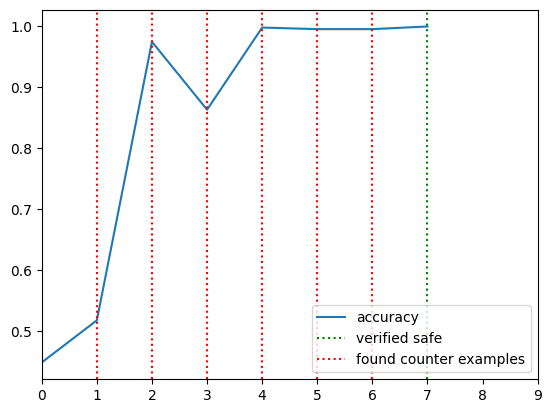

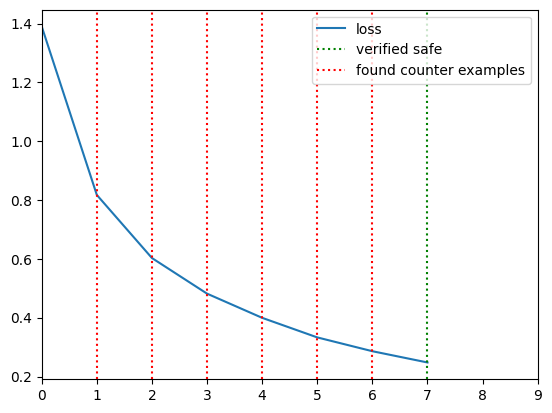

In [12]:
plot_acc_loss(toy_accs, toy_losses, toy_verify_steps)

<IPython.core.display.Javascript object>


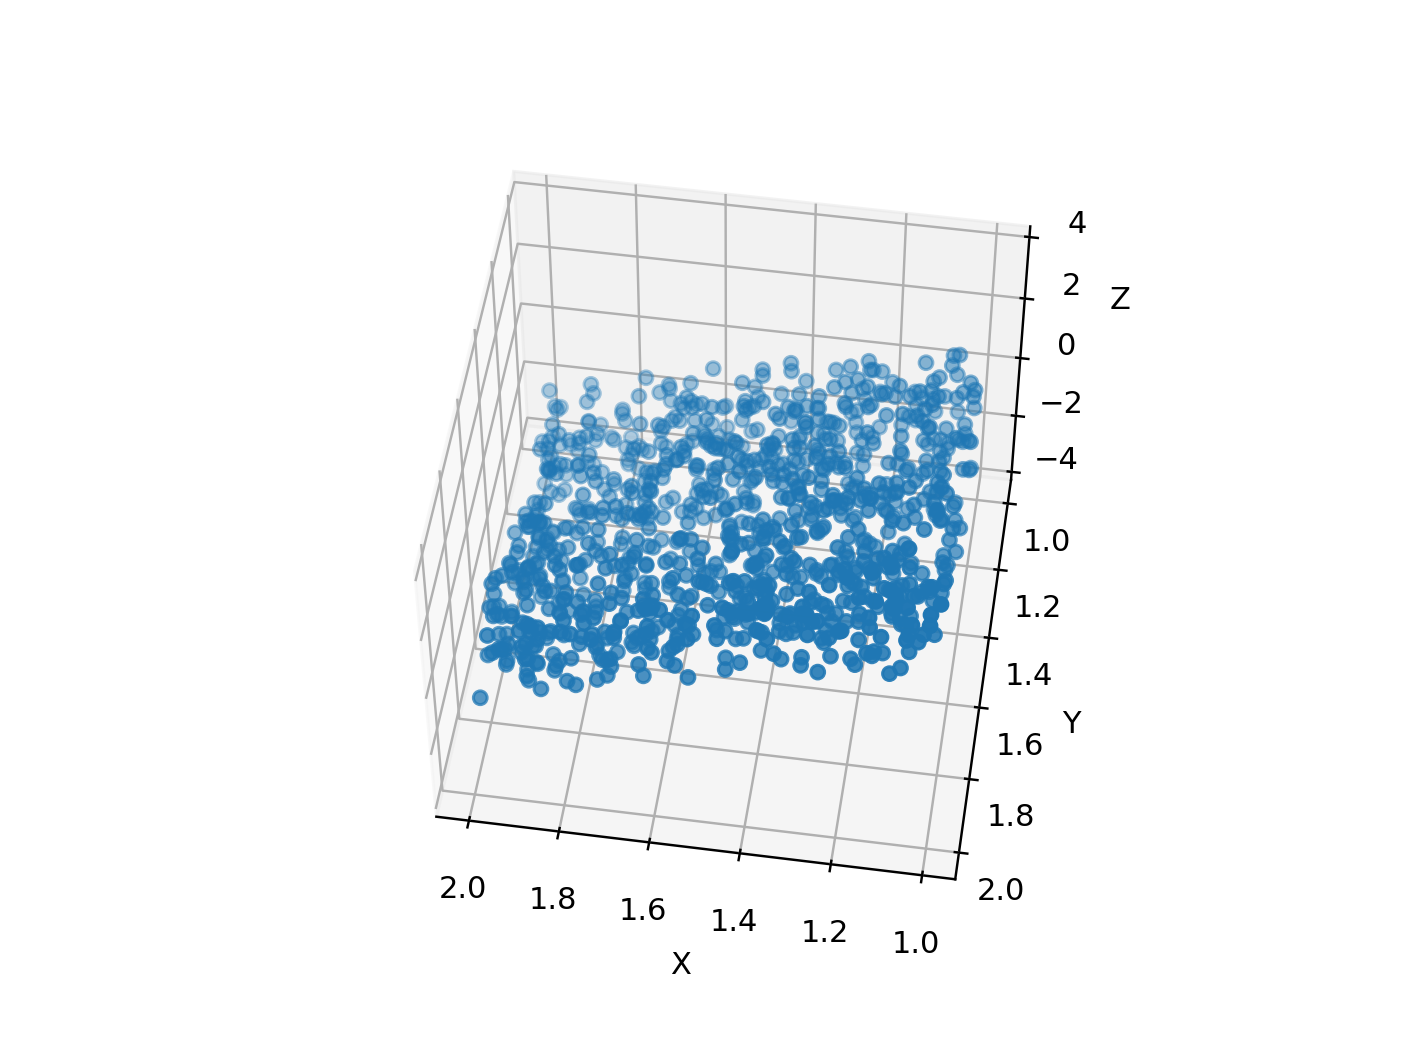

In [63]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

# Fixing random state for reproducibility
np.random.seed(0)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
n = 1000

xs = np.random.uniform(1, 2, n)
ys = np.random.uniform(1, 2, n)
zs = np.random.uniform(0, np.pi, n)
labels = -(xs)**2 + (ys)**2 + np.cos(zs)

ax.scatter(xs, ys, labels)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [43]:
class CardWikiTask(Task):
    
    def set_learning_params(self):
        self.save_prefix="../models/cardesti_wiki/"
        self.device = "cpu"
        self.epochs = 1000
        self.batch_size = 500
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()
        
        self.start_finetune_epoch = False
        self.violated_spec_first = False
        self.max_verify_iter = 1000
        self.counter_example_samling_size = 5000
        
        self.prob_hist = []
    
    def get_model(self):
        return models.FC(1, 4, 1000, 1)
#         return models.FC(2, 4, 1000, 1)
#         return models.FC(1, 2, 100, 1)
    
    def get_data(self):
        training_data = datasets.CardestiWikiDataset("../data/cardesti_wiki/cardesti_wiki.csv")
        testing_data = datasets.CardestiWikiDataset("../data/cardesti_wiki/cardesti_wiki.csv")
        
        return training_data, testing_data
    
    def get_specs(self):
        
        self.X_specs = []
        self.Y_specs = []
        
#         self.X_specs.append(([0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0]))
#         self.Y_specs.append([0, -1]) # dim, direction
        
#         self.X_specs.append(([0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0]))
#         self.Y_specs.append([1, 1]) # dim, direction
        
#         self.X_specs.append(([0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0]))
#         self.Y_specs.append([2, -1]) # dim, direction
        
#         self.X_specs.append(([0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0]))
#         self.Y_specs.append([3, 1]) # dim, direction
        
        self.free_dim_len = 0.02
        
#         self.X_specs.append(([lb, lb], [ub, ub]))
#         self.Y_specs.append([0, -1]) # dim, direction
        
#         self.X_specs.append(([lb, lb], [ub, ub]))
#         self.Y_specs.append([1, 1]) # dim, direction
        
        lb = 0.5-self.free_dim_len
        ub = 0.5+self.free_dim_len
        self.X_specs.append(([lb, lb, lb, lb], [ub, ub, ub, ub]))
        self.Y_specs.append([0, -1]) # dim, direction
        
        self.X_specs.append(([lb, lb, lb, lb], [ub, ub, ub, ub]))
        self.Y_specs.append([1, 1]) # dim, direction
        
#         self.X_specs.append(([lb, lb, lb, lb], [ub, ub, ub, ub]))
#         self.Y_specs.append([2, -1]) # dim, direction
        
#         self.X_specs.append(([lb, lb, lb, lb], [ub, ub, ub, ub]))
#         self.Y_specs.append([3, 1]) # dim, direction
        
        return self.X_specs, self.Y_specs, self.free_dim_len            
    
    def training_data_spec_check(self):
        return 0
    
    def check_specs(self, nnet_path):
        all_safe = True
        results = []
        failed_spec_list = []
        if not self.violated_spec_first:
            self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
        
        status, counter_examples = None, None
        ratio_list = []
        print("====================")
        for j, (X_spec, Y_spec) in enumerate(self.spec_check_list):
            
            print("Y_spec:", Y_spec)
            
            status, counter_examples, ratio = Main.MonoIncVerify(nnet_path, X_spec, Y_spec, sampling_size=self.counter_example_samling_size)
            ratio_list.append(ratio)
            
            results.append(status == "holds")
            if status == "holds":
                print("Verified safe for free_dim_len =", self.free_dim_len)
                results.append(True)
            elif status == "violated":
                print("adding counter example, num=", len(counter_examples))
                for counter_example in counter_examples:
                    gt_y = self.get_label(counter_example)
                    self.training_data.append(counter_example, gt_y)
                    self.testing_data = self.training_data
                failed_spec_list.append((X_spec, Y_spec))
                results.append(False)
            elif status == "unknown":
                self.max_verify_iter *= 2
                failed_spec_list.append((X_spec, Y_spec))
                results.append(False)
        
        self.prob_hist.append(ratio_list)
        print("checked spec count: ", len(self.spec_check_list))
        print("unsafe spec count: ", len(failed_spec_list))

        if len(self.spec_check_list) != len(self.X_specs):
            results = results + [False] * (len(self.X_specs) - len(self.spec_check_list))
            
        if self.violated_spec_first:
            if len(spec_check_list_new) == 0:
                self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
            else:
                self.spec_check_list = failed_spec_list

        return results
    
    def get_label(self, x):
        xs_idx = self.training_data.knn.get_nns_by_vector(x, 3) # will find the 1000 nearest neighbors
        y = np.array([np.mean([self.training_data.ys[idx] for idx in xs_idx])])
#         print("getting_label")
#         print(x)
#         print(xs_idx)
#         print([self.training_data.xs[idx] for idx in xs_idx])
#         print([self.training_data.ys[idx] for idx in xs_idx])
#         print(y)
        return y

    def set_spec_free_dim_len(self):
        pass
    
    def start_verify(self, acc, loss):
        return acc > 0.90
    
    def is_finished(self, results, acc):
        if np.all(results) and acc > 0.90:
            if self.free_dim_len >= 0:
                return True
            else:
                self.free_dim_len = min(self.free_dim_len * 2, 0.5)
                self.set_spec_free_dim_len()
        return False
    
    def acc_cnt_fn(self, pred, y):
        return (abs(pred - y) < 1e-1).sum()
    
    def set_seed(self):
        torch.manual_seed(0)
    
def card_wiki_run():
    task = CardWikiTask()
    accs, losses, verify_steps = train_and_verify(task)
    return accs, losses, verify_steps

In [44]:
data = pd.read_csv("../data/cardesti_wiki/cardesti_wiki.csv", index_col=False)
data = data[data["num_rows"]>500]
data

page_latest_low  page_latest_high  page_len_low  page_len_high  \
0              3531223           6182572         21326         626293   
11               65342           3521649         13994        1392299   
34              796335           4395195          6987        1459031   
93             3856963           6403577         30307        1364423   
114              85432           4731553         34704         317372   
...                ...               ...           ...            ...   
99888          2739010           5668952          4032        1037555   
99926           337470           3276529         10162         910363   
99951          4387772           5981969         18060         848929   
99954          2379400           6295428         11250        1198451   
99977          2438704           6329099         53448         479463   

       num_rows  
0          1953  
11          863  
34         2255  
93         1803  
114         520  
...         ...  
99888     11184  
99926      1022  
99951      1536  
99954      6323  
99977       661  

[3126 rows x 5 columns]

In [45]:
importlib.reload(datasets)
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main
Main.include("verify.jl")
importlib.reload(datasets)
task = CardWikiTask()
accs, losses, verify_steps = train_and_verify(task);

3126
3126
Using cpu device
Epoch 1
-------------------------------
Start finetuning.
fc.0.weight   False
fc.0.bias   False
fc.1.weight   True
fc.1.bias   True
Train Error: 
 Accuracy: 75.4%, Avg loss: 0.011527 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 93.9%, Avg loss: 0.006088 

start verifying
Y_spec: [0, -1]
adding counter example, num= 4004
Y_spec: [1, 1]
adding counter example, num= 4004
checked spec count:  2
unsafe spec count:  2
len(task.training_data) =  11134
len(task.testing_data) =  11134
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.001210 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 99.2%, Avg loss: 0.001643 

start verifying
Y_spec: [0, -1]
adding counter example, num= 4004
Y_spec: [1, 1]
adding counter example, num= 4004
checked spec count:  2
unsafe spec count:  2
len(task.training_data) =  19142
len(task.testing_data) =  19142
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000819 

Epoch 4
-------------------------------
Train Er

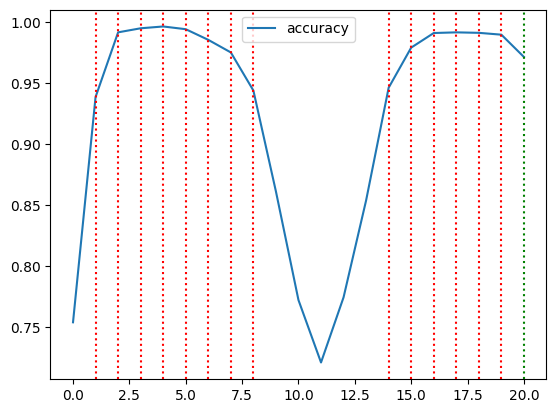

[(1, False), (2, False), (3, False), (4, False), (5, False), (6, False), (7, False), (8, False), (14, False), (15, False), (16, False), (17, False), (18, False), (19, False), (20, True)]


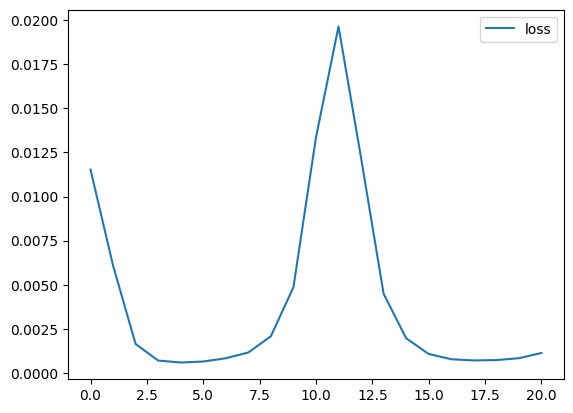

In [46]:
def plot_acc_loss(accs, losses, steps):
    plt.figure()
    plt.plot(accs, label="accuracy")
#     plt.axvline(x = -100, c='g', linestyle=":", label = 'verified safe')
#     plt.axvline(x = -100, c='r', linestyle=":", label = 'found counter examples')
    for t in steps:
        plt.axvline(x=t[0], c='g' if t[1] else 'r', linestyle=":")
#     plt.xlim([-100,len(accs)+100])
#     plt.plot(steps, probs, label="verified prob")
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(losses, label="loss")
    
    print(steps)
#     plt.xlim([-100,len(accs)+100])
    plt.legend()
    plt.show()
    
    
plot_acc_loss(accs, losses, verify_steps)


In [9]:
class MonotonicToyTask(Task):
    
    def set_learning_params(self):
        self.save_prefix="../models/monotonic_toy/"
        self.device = "cpu"
        self.epochs = 1000
        self.batch_size = 1000
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()
        
        self.start_finetune_epoch = False
        self.violated_spec_first = False
        self.max_verify_iter = 1000
        self.counter_example_samling_size = 1000
        
        self.prob_hist = []
    
    def get_model(self):
        return models.FC(1, 3, 100, 1)
    
    def get_data(self):
#         training_data = datasets.MonotonicToyDataset()
#         testing_data = datasets.MonotonicToyDataset()
        
        training_data = datasets.MonotonicNoiseDataset()
        testing_data = datasets.MonotonicNoiseDataset()
        
        return training_data, testing_data
    
    def get_specs(self):
        
        self.X_specs = []
        self.Y_specs = []
        self.X_specs.append(([0.0, 0.0, 0.0], [1.0, 1.0, 1.0]))
        self.Y_specs.append([0, -1]) # dim, direction
        
        self.X_specs.append(([0.0, 0.0, 0.0], [1.0, 1.0, 1.0]))
        self.Y_specs.append([1, 1]) # dim, direction
        
        self.free_dim_len = 0.51
        
        return self.X_specs, self.Y_specs, self.free_dim_len            
    
    def training_data_spec_check(self):
        return 0
    
    def check_specs(self, nnet_path):
        all_safe = True
        results = []
        failed_spec_list = []
        if not self.violated_spec_first:
            self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
        
        status, counter_examples = None, None
        ratio_list = []
        print("====================")
        for j, (X_spec, Y_spec) in enumerate(self.spec_check_list):
            
            print("Y_spec:", Y_spec)
            
            status, counter_examples, ratio = Main.MonoIncVerify(nnet_path, X_spec, Y_spec, sampling_size=self.counter_example_samling_size)
            ratio_list.append(ratio)
            
            results.append(status == "holds")
            if status == "holds":
                print("Verified safe for free_dim_len =", self.free_dim_len)
                results.append(True)
            elif status == "violated":
                print("adding counter example, num=", len(counter_examples))
                for counter_example in counter_examples:
                    gt_y = self.get_label(counter_example)
                    self.training_data.append(counter_example, gt_y)
                    self.testing_data = self.training_data
                failed_spec_list.append((X_spec, Y_spec))
                results.append(False)
            elif status == "unknown":
                self.max_verify_iter *= 2
                failed_spec_list.append((X_spec, Y_spec))
                results.append(False)
        
        self.prob_hist.append(ratio_list)
        print("checked spec count: ", len(self.spec_check_list))
        print("unsafe spec count: ", len(failed_spec_list))

        if len(self.spec_check_list) != len(self.X_specs):
            results = results + [False] * (len(self.X_specs) - len(self.spec_check_list))
            
        if self.violated_spec_first:
            if len(spec_check_list_new) == 0:
                self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
            else:
                self.spec_check_list = failed_spec_list

        return results
    
    def get_label(self, x):
        return np.array([- (x[0]+1)**2 + (x[1]+1)**2])

    def set_spec_free_dim_len(self):
        pass
    
    def start_verify(self, acc, loss):
        return acc > 0.80
    
    def is_finished(self, results, acc):
        if np.all(results) and acc > 0.95:
            if self.free_dim_len >= 0.5:
                return True
            else:
                self.free_dim_len = min(self.free_dim_len * 2, 0.5)
                self.set_spec_free_dim_len()
        return False
    
    def acc_cnt_fn(self, pred, y):
        return (abs(pred - y) < 1e-1).sum()
    
    def set_seed(self):
        torch.manual_seed(0)
    
def mono_toy_run():
    task = MonotonicToyTask()
    accs, losses, verify_steps = train_and_verify(task)
    return accs, losses, verify_steps

In [65]:
importlib.reload(datasets)
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main
Main.include("verify.jl")
importlib.reload(datasets)
task = MonotonicToyTask()
accs, losses, verify_steps = train_and_verify(task);

Using cpu device
Epoch 1
-------------------------------
Start finetuning.
fc.0.weight   False
fc.0.bias   False
fc.1.weight   True
fc.1.bias   True
Train Error: 
 Accuracy: 5.3%, Avg loss: 1.954596 

Test Error: 
 Accuracy: 5.5%, Avg loss: 1.903649 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 5.6%, Avg loss: 1.862335 

Test Error: 
 Accuracy: 5.6%, Avg loss: 1.813532 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 5.7%, Avg loss: 1.773758 

Test Error: 
 Accuracy: 5.7%, Avg loss: 1.726377 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 5.8%, Avg loss: 1.688041 

Test Error: 
 Accuracy: 5.9%, Avg loss: 1.642272 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 6.0%, Avg loss: 1.605336 

Test Error: 
 Accuracy: 6.1%, Avg loss: 1.561288 

Epoch 6
-------------------------------
Train Error: 
 Accuracy: 6.2%, Avg loss: 1.525723 

Test Error: 
 Accuracy: 6.3%, Avg loss: 1.483385 

Epoch 7
-------------------------

Test Error: 
 Accuracy: 29.5%, Avg loss: 0.057612 

Epoch 58
-------------------------------
Train Error: 
 Accuracy: 29.8%, Avg loss: 0.056084 

Test Error: 
 Accuracy: 30.3%, Avg loss: 0.054286 

Epoch 59
-------------------------------
Train Error: 
 Accuracy: 30.5%, Avg loss: 0.052884 

Test Error: 
 Accuracy: 31.0%, Avg loss: 0.051235 

Epoch 60
-------------------------------
Train Error: 
 Accuracy: 31.3%, Avg loss: 0.049950 

Test Error: 
 Accuracy: 31.9%, Avg loss: 0.048438 

Epoch 61
-------------------------------
Train Error: 
 Accuracy: 32.4%, Avg loss: 0.047260 

Test Error: 
 Accuracy: 32.9%, Avg loss: 0.045876 

Epoch 62
-------------------------------
Train Error: 
 Accuracy: 33.4%, Avg loss: 0.044799 

Test Error: 
 Accuracy: 33.9%, Avg loss: 0.043531 

Epoch 63
-------------------------------
Train Error: 
 Accuracy: 34.1%, Avg loss: 0.042547 

Test Error: 
 Accuracy: 34.7%, Avg loss: 0.041388 

Epoch 64
-------------------------------
Train Error: 
 Accuracy: 34.9%,

Train Error: 
 Accuracy: 52.2%, Avg loss: 0.018858 

Test Error: 
 Accuracy: 52.2%, Avg loss: 0.018818 

Epoch 115
-------------------------------
Train Error: 
 Accuracy: 52.3%, Avg loss: 0.018789 

Test Error: 
 Accuracy: 52.3%, Avg loss: 0.018750 

Epoch 116
-------------------------------
Train Error: 
 Accuracy: 52.4%, Avg loss: 0.018721 

Test Error: 
 Accuracy: 52.4%, Avg loss: 0.018682 

Epoch 117
-------------------------------
Train Error: 
 Accuracy: 52.4%, Avg loss: 0.018654 

Test Error: 
 Accuracy: 52.4%, Avg loss: 0.018615 

Epoch 118
-------------------------------
Train Error: 
 Accuracy: 52.5%, Avg loss: 0.018587 

Test Error: 
 Accuracy: 52.5%, Avg loss: 0.018549 

Epoch 119
-------------------------------
Train Error: 
 Accuracy: 52.5%, Avg loss: 0.018522 

Test Error: 
 Accuracy: 52.6%, Avg loss: 0.018484 

Epoch 120
-------------------------------
Train Error: 
 Accuracy: 52.6%, Avg loss: 0.018456 

Test Error: 
 Accuracy: 52.6%, Avg loss: 0.018419 

Epoch 121
---

Test Error: 
 Accuracy: 55.9%, Avg loss: 0.015566 

Epoch 172
-------------------------------
Train Error: 
 Accuracy: 55.9%, Avg loss: 0.015547 

Test Error: 
 Accuracy: 56.0%, Avg loss: 0.015517 

Epoch 173
-------------------------------
Train Error: 
 Accuracy: 56.0%, Avg loss: 0.015497 

Test Error: 
 Accuracy: 56.1%, Avg loss: 0.015468 

Epoch 174
-------------------------------
Train Error: 
 Accuracy: 56.1%, Avg loss: 0.015449 

Test Error: 
 Accuracy: 56.1%, Avg loss: 0.015419 

Epoch 175
-------------------------------
Train Error: 
 Accuracy: 56.2%, Avg loss: 0.015400 

Test Error: 
 Accuracy: 56.2%, Avg loss: 0.015371 

Epoch 176
-------------------------------
Train Error: 
 Accuracy: 56.2%, Avg loss: 0.015351 

Test Error: 
 Accuracy: 56.2%, Avg loss: 0.015322 

Epoch 177
-------------------------------
Train Error: 
 Accuracy: 56.3%, Avg loss: 0.015303 

Test Error: 
 Accuracy: 56.3%, Avg loss: 0.015274 

Epoch 178
-------------------------------
Train Error: 
 Accuracy:

Test Error: 
 Accuracy: 59.8%, Avg loss: 0.013057 

Epoch 229
-------------------------------
Train Error: 
 Accuracy: 59.9%, Avg loss: 0.013042 

Test Error: 
 Accuracy: 59.9%, Avg loss: 0.013017 

Epoch 230
-------------------------------
Train Error: 
 Accuracy: 60.0%, Avg loss: 0.013002 

Test Error: 
 Accuracy: 60.0%, Avg loss: 0.012978 

Epoch 231
-------------------------------
Train Error: 
 Accuracy: 60.0%, Avg loss: 0.012963 

Test Error: 
 Accuracy: 60.1%, Avg loss: 0.012939 

Epoch 232
-------------------------------
Train Error: 
 Accuracy: 60.1%, Avg loss: 0.012924 

Test Error: 
 Accuracy: 60.1%, Avg loss: 0.012899 

Epoch 233
-------------------------------
Train Error: 
 Accuracy: 60.2%, Avg loss: 0.012884 

Test Error: 
 Accuracy: 60.3%, Avg loss: 0.012860 

Epoch 234
-------------------------------
Train Error: 
 Accuracy: 60.3%, Avg loss: 0.012846 

Test Error: 
 Accuracy: 60.3%, Avg loss: 0.012822 

Epoch 235
-------------------------------
Train Error: 
 Accuracy:

Train Error: 
 Accuracy: 63.8%, Avg loss: 0.011010 

Test Error: 
 Accuracy: 63.8%, Avg loss: 0.010988 

Epoch 286
-------------------------------
Train Error: 
 Accuracy: 63.9%, Avg loss: 0.010976 

Test Error: 
 Accuracy: 63.9%, Avg loss: 0.010955 

Epoch 287
-------------------------------
Train Error: 
 Accuracy: 64.0%, Avg loss: 0.010943 

Test Error: 
 Accuracy: 64.0%, Avg loss: 0.010922 

Epoch 288
-------------------------------
Train Error: 
 Accuracy: 64.0%, Avg loss: 0.010910 

Test Error: 
 Accuracy: 64.0%, Avg loss: 0.010889 

Epoch 289
-------------------------------
Train Error: 
 Accuracy: 64.1%, Avg loss: 0.010877 

Test Error: 
 Accuracy: 64.2%, Avg loss: 0.010856 

Epoch 290
-------------------------------
Train Error: 
 Accuracy: 64.1%, Avg loss: 0.010844 

Test Error: 
 Accuracy: 64.3%, Avg loss: 0.010823 

Epoch 291
-------------------------------
Train Error: 
 Accuracy: 64.2%, Avg loss: 0.010811 

Test Error: 
 Accuracy: 64.3%, Avg loss: 0.010790 

Epoch 292
---

Test Error: 
 Accuracy: 67.7%, Avg loss: 0.009243 

Epoch 343
-------------------------------
Train Error: 
 Accuracy: 67.7%, Avg loss: 0.009233 

Test Error: 
 Accuracy: 67.8%, Avg loss: 0.009215 

Epoch 344
-------------------------------
Train Error: 
 Accuracy: 67.8%, Avg loss: 0.009205 

Test Error: 
 Accuracy: 67.9%, Avg loss: 0.009187 

Epoch 345
-------------------------------
Train Error: 
 Accuracy: 67.9%, Avg loss: 0.009178 

Test Error: 
 Accuracy: 68.0%, Avg loss: 0.009159 

Epoch 346
-------------------------------
Train Error: 
 Accuracy: 68.0%, Avg loss: 0.009150 

Test Error: 
 Accuracy: 68.1%, Avg loss: 0.009131 

Epoch 347
-------------------------------
Train Error: 
 Accuracy: 68.1%, Avg loss: 0.009122 

Test Error: 
 Accuracy: 68.2%, Avg loss: 0.009104 

Epoch 348
-------------------------------
Train Error: 
 Accuracy: 68.1%, Avg loss: 0.009095 

Test Error: 
 Accuracy: 68.2%, Avg loss: 0.009076 

Epoch 349
-------------------------------
Train Error: 
 Accuracy:

Test Error: 
 Accuracy: 71.9%, Avg loss: 0.007791 

Epoch 400
-------------------------------
Train Error: 
 Accuracy: 71.9%, Avg loss: 0.007785 

Test Error: 
 Accuracy: 72.0%, Avg loss: 0.007768 

Epoch 401
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.007762 

Test Error: 
 Accuracy: 72.1%, Avg loss: 0.007745 

Epoch 402
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.007740 

Test Error: 
 Accuracy: 72.1%, Avg loss: 0.007722 

Epoch 403
-------------------------------
Train Error: 
 Accuracy: 72.2%, Avg loss: 0.007717 

Test Error: 
 Accuracy: 72.2%, Avg loss: 0.007700 

Epoch 404
-------------------------------
Train Error: 
 Accuracy: 72.2%, Avg loss: 0.007695 

Test Error: 
 Accuracy: 72.2%, Avg loss: 0.007677 

Epoch 405
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss: 0.007672 

Test Error: 
 Accuracy: 72.3%, Avg loss: 0.007655 

Epoch 406
-------------------------------
Train Error: 
 Accuracy:

Test Error: 
 Accuracy: 76.6%, Avg loss: 0.006625 

Epoch 457
-------------------------------
Train Error: 
 Accuracy: 76.6%, Avg loss: 0.006621 

Test Error: 
 Accuracy: 76.7%, Avg loss: 0.006607 

Epoch 458
-------------------------------
Train Error: 
 Accuracy: 76.7%, Avg loss: 0.006603 

Test Error: 
 Accuracy: 76.7%, Avg loss: 0.006589 

Epoch 459
-------------------------------
Train Error: 
 Accuracy: 76.7%, Avg loss: 0.006585 

Test Error: 
 Accuracy: 76.8%, Avg loss: 0.006572 

Epoch 460
-------------------------------
Train Error: 
 Accuracy: 76.8%, Avg loss: 0.006568 

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.006554 

Epoch 461
-------------------------------
Train Error: 
 Accuracy: 76.9%, Avg loss: 0.006550 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.006536 

Epoch 462
-------------------------------
Train Error: 
 Accuracy: 77.1%, Avg loss: 0.006532 

Test Error: 
 Accuracy: 77.1%, Avg loss: 0.006519 

Epoch 463
-------------------------------
Train Error: 
 Accuracy:

Train Error: 
 Accuracy: 80.1%, Avg loss: 0.005819 

Test Error: 
 Accuracy: 80.2%, Avg loss: 0.005816 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_data) =  10000
Test Error: 
 Accuracy: 80.2%, Avg loss: 0.005816 

Epoch 508
-------------------------------
Train Error: 
 Accuracy: 80.2%, Avg loss: 0.005805 

Test Error: 
 Accuracy: 80.3%, Avg loss: 0.005802 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_data) =  10000
Test Error: 
 Accuracy: 80.3%, Avg loss: 0.005802 

Epoch 509
-------------------------------
Train Error: 
 Accuracy: 80.2%, Avg loss: 0.005791 

Test Error: 
 Accuracy: 80.3%, Avg loss: 0.005788 

start verifying
Y_spec: [0, -1]

Test Error: 
 Accuracy: 81.5%, Avg loss: 0.005576 

Epoch 526
-------------------------------
Train Error: 
 Accuracy: 81.3%, Avg loss: 0.005562 

Test Error: 
 Accuracy: 81.6%, Avg loss: 0.005563 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_data) =  10000
Test Error: 
 Accuracy: 81.6%, Avg loss: 0.005563 

Epoch 527
-------------------------------
Train Error: 
 Accuracy: 81.4%, Avg loss: 0.005550 

Test Error: 
 Accuracy: 81.7%, Avg loss: 0.005550 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_data) =  10000
Test Error: 
 Accuracy: 81.7%, Avg loss: 0.005550 

Epoch 528
-------------------------------
Train Error: 
 Accuracy: 81.4%, Avg loss: 

Test Error: 
 Accuracy: 82.7%, Avg loss: 0.005345 

Epoch 545
-------------------------------
Train Error: 
 Accuracy: 82.3%, Avg loss: 0.005329 

Test Error: 
 Accuracy: 82.8%, Avg loss: 0.005333 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_data) =  10000
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.005333 

Epoch 546
-------------------------------
Train Error: 
 Accuracy: 82.3%, Avg loss: 0.005317 

Test Error: 
 Accuracy: 82.8%, Avg loss: 0.005322 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_data) =  10000
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.005322 

Epoch 547
-------------------------------
Train Error: 
 Accuracy: 82.3%, Avg loss: 

Train Error: 
 Accuracy: 83.3%, Avg loss: 0.005117 

Test Error: 
 Accuracy: 83.8%, Avg loss: 0.005124 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_data) =  10000
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.005124 

Epoch 565
-------------------------------
Train Error: 
 Accuracy: 83.4%, Avg loss: 0.005107 

Test Error: 
 Accuracy: 83.8%, Avg loss: 0.005114 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_data) =  10000
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.005114 

Epoch 566
-------------------------------
Train Error: 
 Accuracy: 83.5%, Avg loss: 0.005096 

Test Error: 
 Accuracy: 83.9%, Avg loss: 0.005104 

start verifying
Y_spec: [0, -1]

Train Error: 
 Accuracy: 84.4%, Avg loss: 0.004926 

Test Error: 
 Accuracy: 85.1%, Avg loss: 0.004935 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_data) =  10000
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.004935 

Epoch 584
-------------------------------
Train Error: 
 Accuracy: 84.5%, Avg loss: 0.004916 

Test Error: 
 Accuracy: 85.1%, Avg loss: 0.004926 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_data) =  10000
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.004926 

Epoch 585
-------------------------------
Train Error: 
 Accuracy: 84.5%, Avg loss: 0.004907 

Test Error: 
 Accuracy: 85.2%, Avg loss: 0.004916 

start verifying
Y_spec: [0, -1]

Test Error: 
 Accuracy: 85.9%, Avg loss: 0.004773 

Epoch 602
-------------------------------
Train Error: 
 Accuracy: 85.5%, Avg loss: 0.004753 

Test Error: 
 Accuracy: 85.9%, Avg loss: 0.004764 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_data) =  10000
Test Error: 
 Accuracy: 85.9%, Avg loss: 0.004764 

Epoch 603
-------------------------------
Train Error: 
 Accuracy: 85.5%, Avg loss: 0.004744 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.004756 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_data) =  10000
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.004756 

Epoch 604
-------------------------------
Train Error: 
 Accuracy: 85.6%, Avg loss: 

Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_data) =  10000
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.004617 

Epoch 621
-------------------------------
Train Error: 
 Accuracy: 86.3%, Avg loss: 0.004597 

Test Error: 
 Accuracy: 86.8%, Avg loss: 0.004610 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_data) =  10000
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.004610 

Epoch 622
-------------------------------
Train Error: 
 Accuracy: 86.3%, Avg loss: 0.004589 

Test Error: 
 Accuracy: 86.8%, Avg loss: 0.004602 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
Verified safe for free_dim_len = 0.51
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  10000
len(task.testing_dat

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000567 

Epoch 639
-------------------------------
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.000239 

Test Error: 
 Accuracy: 99.4%, Avg loss: 0.000518 

start verifying
Y_spec: [0, -1]
Verified safe for free_dim_len = 0.51
Y_spec: [1, 1]
adding counter example, num= 271107
checked spec count:  2
unsafe spec count:  1
len(task.training_data) =  538071
len(task.testing_data) =  538071
Test Error: 
 Accuracy: 50.4%, Avg loss: 0.061771 

Epoch 640
-------------------------------
Train Error: 
 Accuracy: 87.1%, Avg loss: 0.005534 



KeyboardInterrupt: 

<IPython.core.display.Javascript object>


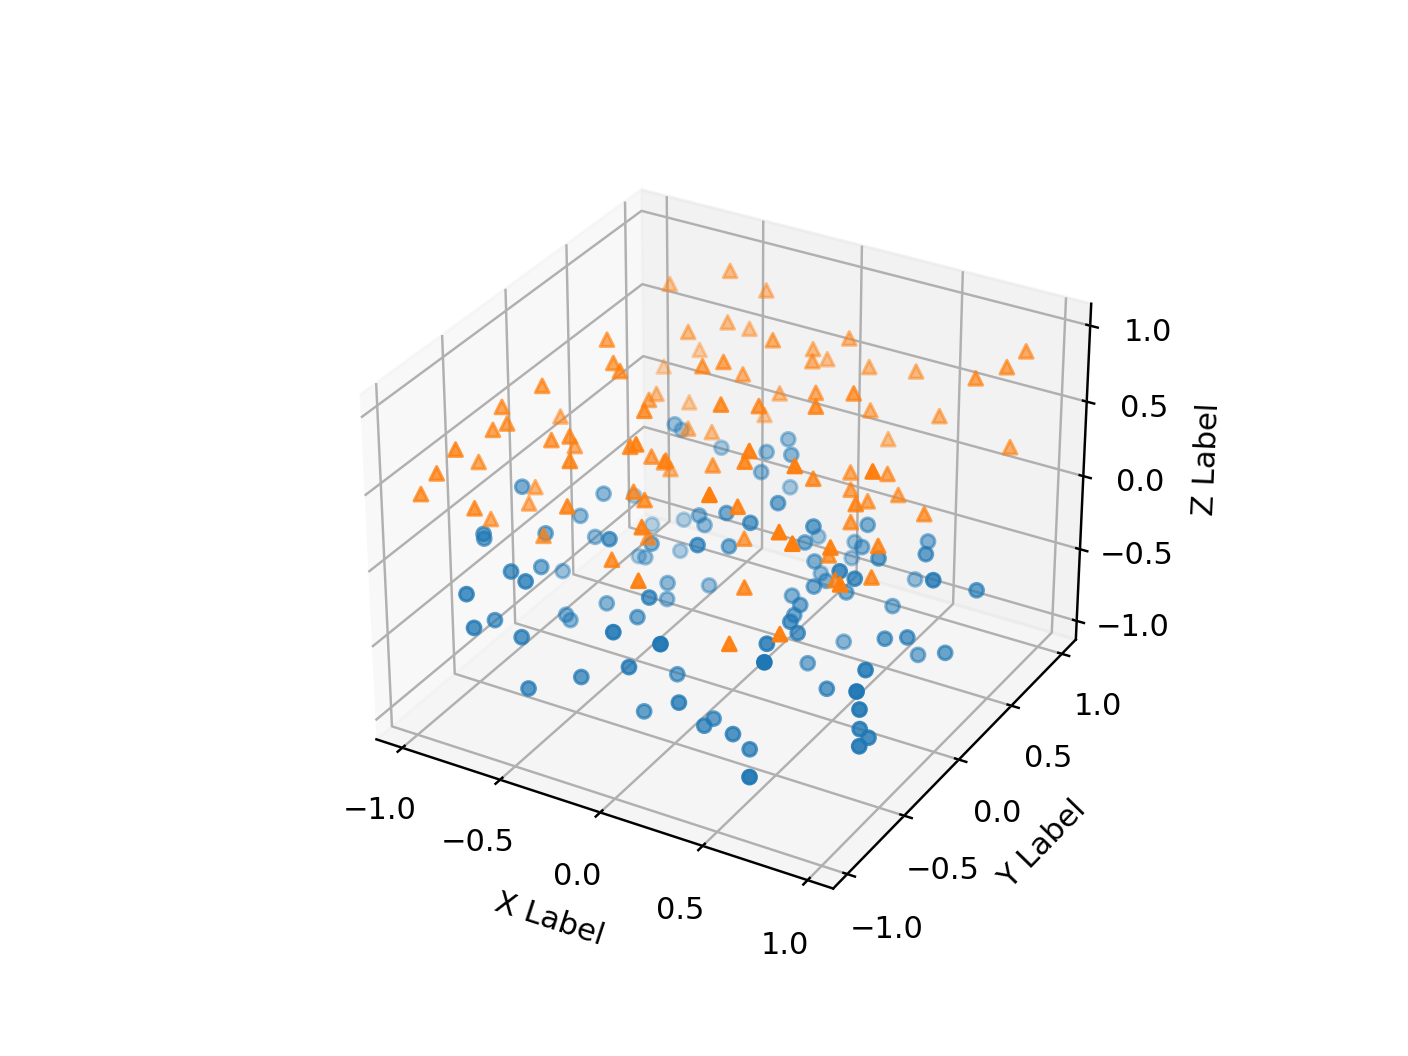

[array([ 0.09762701,  0.35563308, -0.6882041 ], dtype=float32), array([ 0.43037874, -0.45998406, -0.30365652], dtype=float32), array([ 0.20552675,  0.47038805, -0.6222482 ], dtype=float32), array([ 0.08976637,  0.9243771 , -0.8203963 ], dtype=float32), array([-0.1526904 , -0.50249374, -0.9753213 ], dtype=float32), array([ 0.29178822,  0.15231466, -0.93275034], dtype=float32), array([-0.12482557,  0.18408386, -0.32060722], dtype=float32), array([ 0.78354603,  0.14450382, -0.54630315], dtype=float32), array([ 0.92732555, -0.55383676, -0.46342078], dtype=float32), array([-0.23311697,  0.905498  , -0.1033287 ], dtype=float32), array([ 0.5834501 , -0.10574924, -0.00966105], dtype=float32), array([ 0.05778984,  0.69281733, -0.783103  ], dtype=float32), array([ 0.13608912,  0.39895856, -0.3369218 ], dtype=float32), array([ 0.85119325, -0.4051261 , -0.73667765], dtype=float32), array([-0.85792786,  0.62759566, -0.979349  ], dtype=float32), array([-0.8257414 , -0.20698851, -0.24162135], dtype=f

In [10]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

# Fixing random state for reproducibility
np.random.seed(0)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
n = 100

data = []
labels = []

for m, label, zlow, zhigh in [('o', 0, -1, -0), ('^', 1, 0, 1)]:
    xs = np.random.uniform(-1, 1, n)
    ys = np.random.uniform(-1, 1, n)
    zs = np.random.uniform(zlow, zhigh, n)
    data += list(map(lambda a:np.array(a).astype('float32'), list(zip(xs, ys, zs))))
    labels += label * list(np.ones((len(xs),1)).astype('float32'))

    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

print(data)
print(labels)

In [23]:
data = pd.read_csv("../data/bloom_crime/crime.csv")
display(data)

INCIDENT_NUMBER  OFFENSE_CODE    OFFENSE_CODE_GROUP  \
0           I182070945           619               Larceny   
1           I182070943          1402             Vandalism   
2           I182070941          3410                 Towed   
3           I182070940          3114  Investigate Property   
4           I182070938          3114  Investigate Property   
...                ...           ...                   ...   
319068   I050310906-00          3125       Warrant Arrests   
319069   I030217815-08           111              Homicide   
319070   I030217815-08          3125       Warrant Arrests   
319071   I010370257-00          3125       Warrant Arrests   
319072       142052550          3125       Warrant Arrests   

                        OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
0                        LARCENY ALL OTHERS      D14            808      NaN   
1                                 VANDALISM      C11            347      NaN   
2                       TOWED MOTOR VEHICLE       D4            151      NaN   
3                      INVESTIGATE PROPERTY       D4            272      NaN   
4                      INVESTIGATE PROPERTY       B3            421      NaN   
...                                     ...      ...            ...      ...   
319068                       WARRANT ARREST       D4            285      NaN   
319069  MURDER, NON-NEGLIGIENT MANSLAUGHTER      E18            520      NaN   
319070                       WARRANT ARREST      E18            520      NaN   
319071                       WARRANT ARREST      E13            569      NaN   
319072                       WARRANT ARREST       D4            903      NaN   

           OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR    UCR_PART  \
0       2018-09-02 13:00:00  2018      9      Sunday    13    Part One   
1       2018-08-21 00:00:00  2018      8     Tuesday     0    Part Two   
2       2018-09-03 19:27:00  2018      9      Monday    19  Part Three   
3       2018-09-03 21:16:00  2018      9      Monday    21  Part Three   
4       2018-09-03 21:05:00  2018      9      Monday    21  Part Three   
...                     ...   ...    ...         ...   ...         ...   
319068  2016-06-05 17:25:00  2016      6      Sunday    17  Part Three   
319069  2015-07-09 13:38:00  2015      7    Thursday    13    Part One   
319070  2015-07-09 13:38:00  2015      7    Thursday    13  Part Three   
319071  2016-05-31 19:35:00  2016      5     Tuesday    19  Part Three   
319072  2015-06-22 00:12:00  2015      6      Monday     0  Part Three   

                   STREET        Lat       Long                     Location  
0              LINCOLN ST  42.357791 -71.139371  (42.35779134, -71.13937053)  
1                HECLA ST  42.306821 -71.060300  (42.30682138, -71.06030035)  
2             CAZENOVE ST  42.346589 -71.072429  (42.34658879, -71.07242943)  
3              NEWCOMB ST  42.334182 -71.078664  (42.33418175, -71.07866441)  
4                DELHI ST  42.275365 -71.090361  (42.27536542, -71.09036101)  
...                   ...        ...        ...                          ...  
319068        COVENTRY ST  42.336951 -71.085748  (42.33695098, -71.08574813)  
319069           RIVER ST  42.255926 -71.123172  (42.25592648, -71.12317207)  
319070           RIVER ST  42.255926 -71.123172  (42.25592648, -71.12317207)  
319071  NEW WASHINGTON ST  42.302333 -71.111565  (42.30233307, -71.11156487)  
319072      WASHINGTON ST  42.333839 -71.080290  (42.33383935, -71.08029038)  

[319073 rows x 17 columns]

In [81]:
xs = np.array(list(zip(data.Lat, data.Long)))

In [72]:
dataset = datasets.CrimeDataset("../data/bloom_crime/crime.csv")

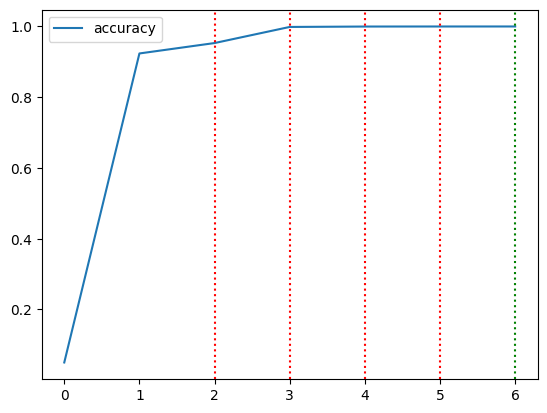

[(2, False), (3, False), (4, False), (5, False), (6, True)]


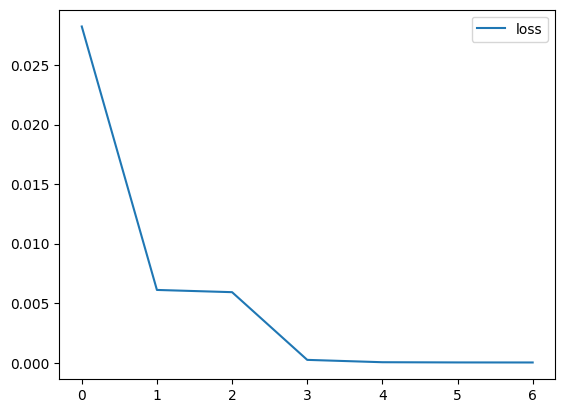

In [73]:
class Rect():
    def __init__(self, lx, ly, hx, hy):
        self.lx = lx
        self.ly = ly
        self.hx = hx
        self.hy = hy
    def divide(self):
        mx = (self.lx + self.hx)/2
        my = (self.ly + self.hy)/2
        
        if self.hx - self.lx > self.hy - self.ly:
            return Rect(self.lx, self.ly, mx, self.hy), Rect(mx, self.ly, self.hx, self.hy)
        else:
            return Rect(self.lx, self.ly, self.hx, my), Rect(self.lx, my, self.hx, self.hy)
            
def check(rect, data):
    exists = (data[:,0] >= rect.lx) & (data[:,0] <= rect.hx) & (data[:,1] >= rect.ly) & (data[:,1] <= rect.hy)
    return np.any(exists)

def get_safe_rects(depth, max_depth, rect, data):
    contain_data = check(rect, data)
    
    if not contain_data:
        return [rect]
    
    if depth > max_depth:
        return []
    
    rect1, rect2 = rect.divide()
    
    return get_safe_rects(depth+1, max_depth, rect1, data) + get_safe_rects(depth+1, max_depth, rect2, data)

safe_rects = get_safe_rects(0, 9, Rect(0,0,1,1), np.array(dataset.xs))
area = np.sum([(r.hx-r.lx)*(r.hy-r.ly) for r in safe_rects])
print(len(safe_rects))
print(area)


119
0.578125


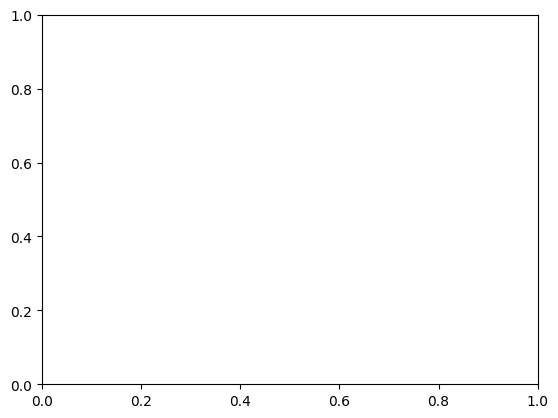

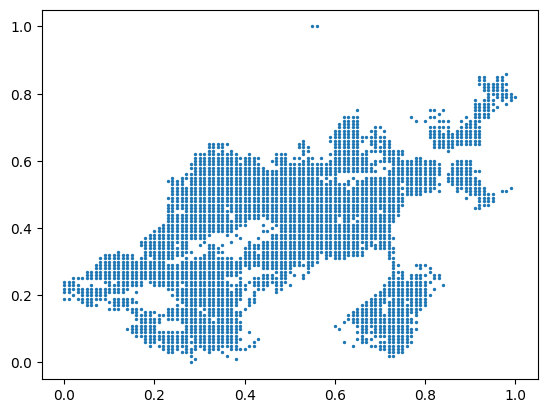

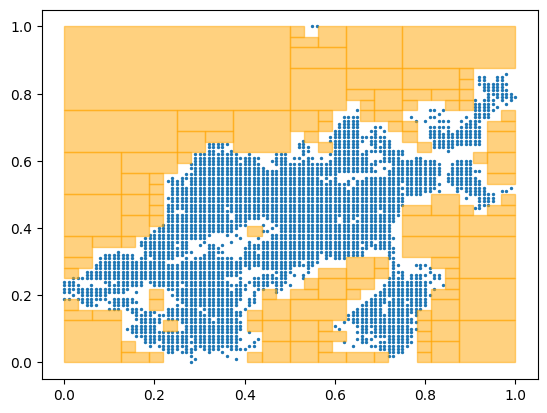

In [74]:
fig, ax = plt.subplots()
xs = np.array(dataset.xs)
ax.scatter(xs[:,0], xs[:,1], s=2)
for rect in safe_rects:
    ax.add_patch(patches.Rectangle((rect.lx, rect.ly), rect.hx-rect.lx, rect.hy-rect.ly, linewidth=1, edgecolor='orange', facecolor='orange', alpha=.5))
plt.show()

In [66]:
class BloomCrimeTask(Task):
    
    def set_learning_params(self):
        self.save_prefix="../models/bloom_crime/"
        self.device = "cpu"
        self.epochs = 10000
        self.batch_size = 100
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10]))
        
        self.start_finetune_epoch = False
        self.violated_spec_first = False
        self.max_verify_iter = 1000
        self.min_verify_size = 0.001
        self.counter_example_samling_size = 10000
        
        self.prob_hist = []
    
    def get_model(self):
        return models.FC(1, 2, 300, 1)
    
    def get_data(self):
        training_data = datasets.CrimeDataset("../data/bloom_crime/crime.csv")
        testing_data = datasets.CrimeDataset("../data/bloom_crime/crime.csv")
        self.negative_data = datasets.CrimeDataset("../data/bloom_crime/crime.csv")
        self.negative_dataloader = DataLoader(self.negative_data, batch_size=1000)
    
        return training_data, testing_data
    
    def get_specs(self):
        class Rect():
            def __init__(self, lx, ly, hx, hy):
                self.lx = lx
                self.ly = ly
                self.hx = hx
                self.hy = hy
            def divide(self):
                mx = (self.lx + self.hx)/2
                my = (self.ly + self.hy)/2

                if self.hx - self.lx > self.hy - self.ly:
                    return Rect(self.lx, self.ly, mx, self.hy), Rect(mx, self.ly, self.hx, self.hy)
                else:
                    return Rect(self.lx, self.ly, self.hx, my), Rect(self.lx, my, self.hx, self.hy)

        def check(rect, data):
            exists = (data[:,0] >= rect.lx) & (data[:,0] <= rect.hx) & (data[:,1] >= rect.ly) & (data[:,1] <= rect.hy)
            return np.any(exists)

        def get_safe_rects(depth, max_depth, rect, data):
            contain_data = check(rect, data)

            if not contain_data:
                return [rect]

            if depth > max_depth:
                return []

            rect1, rect2 = rect.divide()

            return get_safe_rects(depth+1, max_depth, rect1, data) + get_safe_rects(depth+1, max_depth, rect2, data)

        self.safe_rects = get_safe_rects(0, 9, Rect(0,0,1,1), np.array(self.negative_data.xs))
        self.total_spec_volume = np.sum([(r.hx-r.lx)*(r.hy-r.ly) for r in self.safe_rects])
        
        self.X_specs = []
        self.Y_specs = []
        
        for rect in self.safe_rects:
            self.X_specs.append(([rect.lx, rect.ly], [rect.hx, rect.hy]))
            self.Y_specs.append([np.ones((1,1)), np.zeros(1)])
        
#         self.X_specs.append(([-1.0, -1.0, 0.0], [1.0, 1.0, 1.0]))
#         self.Y_specs.append([-np.ones((1,1)), np.zeros(1)])
        
        self.free_dim_len = 0.51
        
        return self.X_specs, self.Y_specs, self.free_dim_len            
    
    def training_data_spec_check(self):
        return 0
    
    def draw(self):
        fig, ax = plt.subplots()
        xs = np.array(self.training_data.xs)
        ax.scatter(xs[:,0], xs[:,1], c=self.training_data.ys, s=2)
        for rect in self.safe_rects:
            ax.add_patch(patches.Rectangle((rect.lx, rect.ly), rect.hx-rect.lx, rect.hy-rect.ly, linewidth=1, edgecolor='orange', facecolor='orange', alpha=.5))
        plt.show()
        
        
    def check_specs(self, nnet_path):
        all_safe = True
        results = []
        spec_check_list_new = []
        if not self.violated_spec_first:
            self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
        
        self.probs = [[] for i in range(len(self.X_specs))]
        status, counter_examples = None, None
        total_verified_volume = 0
        for j, (X_spec, Y_spec) in enumerate(self.spec_check_list):
            
            spec_volume = np.prod(np.array(X_spec[1]) - X_spec[0])
            status, verified_volume, counter_examples = Main.prob_verify_Neurify(nnet_path, X_spec, Y_spec, 0.7, min_size=self.min_verify_size, sampling_size=int(spec_volume*self.counter_example_samling_size+1))
            print(verified_volume, '/', spec_volume, '=', verified_volume/spec_volume)
            total_verified_volume += verified_volume
            
            results.append(status == "holds")
            if status == "holds":
                print("Verified safe for free_dim_len =", self.free_dim_len)
                results.append(True)
            elif status == "violated":
                print("adding counter example, num=", len(counter_examples))
                for counter_example in counter_examples:
                    gt_y = self.get_label(counter_example)
                    self.training_data.append(counter_example, gt_y)
                    self.testing_data = self.training_data
                spec_check_list_new.append((X_spec, Y_spec))
                results.append(False)
            elif status == "unknown":
                self.max_verify_iter *= 2
                spec_check_list_new.append((X_spec, Y_spec))
                results.append(False)
        
        verified_prob = total_verified_volume / self.total_spec_volume
        print("Total verified volume: ", total_verified_volume)
        print("Total spec volume:     ", self.total_spec_volume)
        print("verified prob:         ", verified_prob)
        
        self.prob_hist.append(verified_prob)
        print("checked spec count: ", len(self.spec_check_list))
        print("unsafe spec count: ", len(spec_check_list_new))

        if len(self.spec_check_list) != len(self.X_specs):
            results = results + [False] * (len(self.X_specs) - len(self.spec_check_list))
            
        if self.violated_spec_first:
            if len(spec_check_list_new) == 0:
                self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
            else:
                self.spec_check_list = spec_check_list_new
        
        self.draw()
        
        return verified_prob > 0.7
    
    def get_label(self, x):
        return np.zeros(1).astype('float32')

    def set_spec_free_dim_len(self):
        pass
    
    def start_verify(self, train_acc, train_loss):
        if train_acc < 0.75:
            return False
        neg_acc, neg_loss = test(self.negative_dataloader, self.model, self.loss_fn, self.device, self.acc_cnt_fn)
        print("Negative data accuracy:", neg_acc)
        return train_acc > 0.75 and neg_acc > 0.80
    
    
    def is_finished(self, results, acc):
        if np.all(results):
            return True
        if np.all(results) and acc > 0.95:
            if self.free_dim_len >= 0.5:
                return True
            else:
                self.free_dim_len = min(self.free_dim_len * 2, 0.5)
                self.set_spec_free_dim_len()
        return False
    
    def acc_cnt_fn(self, pred, y):
        return (((pred > 0) != y).sum(axis=-1) == 0).sum()
    
    def set_seed(self):
        torch.manual_seed(0)
    
def bloom_crime_run():
    task = BloomCrimeTask()
    accs, losses, verify_steps = train_and_verify(task)
    return accs, losses, verify_steps

In [67]:
importlib.reload(datasets)
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main
Main.include("verify.jl")

<PyCall.jlwrap sample_counter_examples>

Using cpu device
Epoch 1
-------------------------------
Start finetuning.
fc.0.weight   False
fc.0.bias   False
fc.1.weight   True
fc.1.bias   True
Train Error: 
 Accuracy: 83.1%, Avg loss: 4.728132 

Test Error: 
 Accuracy: 100.0%, Avg loss: 2.164739 

Negative data accuracy: tensor(1.)
start verifying
0 / 0.015625 = 0.0
adding counter example, num= 144
0 / 0.001953125 = 0.0
adding counter example, num= 20
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.001953125 = 0.0
adding counter example, num= 20
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.001953125 = 0.0
adding counter example, num= 20
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.00390625 = 0.0
adding counter example, num= 40
0 / 0.0009765625 = 0.0
adding counter exam

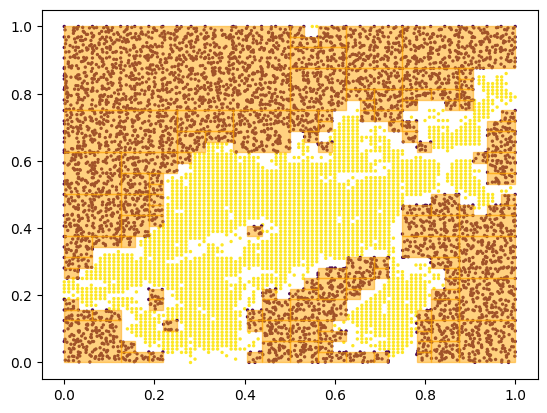

len(task.training_data) =  8496
len(task.testing_data) =  8496
Test Error: 
 Accuracy: 35.1%, Avg loss: 1.921697 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 35.1%, Avg loss: 2.062634 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 35.1%, Avg loss: 1.977247 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 35.1%, Avg loss: 2.049276 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 35.1%, Avg loss: 2.014041 

Epoch 6
-------------------------------
Train Error: 
 Accuracy: 35.1%, Avg loss: 1.971748 

Epoch 7
-------------------------------
Train Error: 
 Accuracy: 35.1%, Avg loss: 1.932200 

Epoch 8
-------------------------------
Train Error: 
 Accuracy: 35.1%, Avg loss: 1.895579 

Epoch 9
-------------------------------
Train Error: 
 Accuracy: 35.1%, Avg loss: 1.862028 

Epoch 10
-------------------------------
Train Error: 
 Accuracy: 35.5%, Avg loss: 1.831468 

Epoch 11
-------------------------------
Train 

Train Error: 
 Accuracy: 62.7%, Avg loss: 1.197780 

Epoch 91
-------------------------------
Train Error: 
 Accuracy: 62.9%, Avg loss: 1.195027 

Epoch 92
-------------------------------
Train Error: 
 Accuracy: 63.0%, Avg loss: 1.192328 

Epoch 93
-------------------------------
Train Error: 
 Accuracy: 63.1%, Avg loss: 1.189682 

Epoch 94
-------------------------------
Train Error: 
 Accuracy: 63.2%, Avg loss: 1.187086 

Epoch 95
-------------------------------
Train Error: 
 Accuracy: 63.3%, Avg loss: 1.184541 

Epoch 96
-------------------------------
Train Error: 
 Accuracy: 63.4%, Avg loss: 1.182045 

Epoch 97
-------------------------------
Train Error: 
 Accuracy: 63.5%, Avg loss: 1.179596 

Epoch 98
-------------------------------
Train Error: 
 Accuracy: 63.5%, Avg loss: 1.177194 

Epoch 99
-------------------------------
Train Error: 
 Accuracy: 63.6%, Avg loss: 1.174837 

Epoch 100
-------------------------------
Train Error: 
 Accuracy: 63.7%, Avg loss: 1.172524 

Epoch 

Train Error: 
 Accuracy: 68.2%, Avg loss: 1.071491 

Epoch 178
-------------------------------
Train Error: 
 Accuracy: 68.3%, Avg loss: 1.070735 

Epoch 179
-------------------------------
Train Error: 
 Accuracy: 68.4%, Avg loss: 1.069988 

Epoch 180
-------------------------------
Train Error: 
 Accuracy: 68.4%, Avg loss: 1.069247 

Epoch 181
-------------------------------
Train Error: 
 Accuracy: 68.5%, Avg loss: 1.068514 

Epoch 182
-------------------------------
Train Error: 
 Accuracy: 68.5%, Avg loss: 1.067788 

Epoch 183
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss: 1.067069 

Epoch 184
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss: 1.066356 

Epoch 185
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss: 1.065651 

Epoch 186
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss: 1.064952 

Epoch 187
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss: 1.064259

Train Error: 
 Accuracy: 70.3%, Avg loss: 1.023785 

Epoch 265
-------------------------------
Train Error: 
 Accuracy: 70.3%, Avg loss: 1.023370 

Epoch 266
-------------------------------
Train Error: 
 Accuracy: 70.3%, Avg loss: 1.022957 

Epoch 267
-------------------------------
Train Error: 
 Accuracy: 70.3%, Avg loss: 1.022545 

Epoch 268
-------------------------------
Train Error: 
 Accuracy: 70.3%, Avg loss: 1.022135 

Epoch 269
-------------------------------
Train Error: 
 Accuracy: 70.4%, Avg loss: 1.021728 

Epoch 270
-------------------------------
Train Error: 
 Accuracy: 70.4%, Avg loss: 1.021321 

Epoch 271
-------------------------------
Train Error: 
 Accuracy: 70.4%, Avg loss: 1.020917 

Epoch 272
-------------------------------
Train Error: 
 Accuracy: 70.4%, Avg loss: 1.020515 

Epoch 273
-------------------------------
Train Error: 
 Accuracy: 70.4%, Avg loss: 1.020114 

Epoch 274
-------------------------------
Train Error: 
 Accuracy: 70.4%, Avg loss: 1.019715

Train Error: 
 Accuracy: 71.5%, Avg loss: 0.992931 

Epoch 352
-------------------------------
Train Error: 
 Accuracy: 71.5%, Avg loss: 0.992623 

Epoch 353
-------------------------------
Train Error: 
 Accuracy: 71.5%, Avg loss: 0.992316 

Epoch 354
-------------------------------
Train Error: 
 Accuracy: 71.5%, Avg loss: 0.992010 

Epoch 355
-------------------------------
Train Error: 
 Accuracy: 71.5%, Avg loss: 0.991705 

Epoch 356
-------------------------------
Train Error: 
 Accuracy: 71.5%, Avg loss: 0.991401 

Epoch 357
-------------------------------
Train Error: 
 Accuracy: 71.5%, Avg loss: 0.991097 

Epoch 358
-------------------------------
Train Error: 
 Accuracy: 71.5%, Avg loss: 0.990794 

Epoch 359
-------------------------------
Train Error: 
 Accuracy: 71.6%, Avg loss: 0.990492 

Epoch 360
-------------------------------
Train Error: 
 Accuracy: 71.6%, Avg loss: 0.990191 

Epoch 361
-------------------------------
Train Error: 
 Accuracy: 71.6%, Avg loss: 0.989891

Train Error: 
 Accuracy: 72.3%, Avg loss: 0.968762 

Epoch 439
-------------------------------
Train Error: 
 Accuracy: 72.3%, Avg loss: 0.968511 

Epoch 440
-------------------------------
Train Error: 
 Accuracy: 72.3%, Avg loss: 0.968259 

Epoch 441
-------------------------------
Train Error: 
 Accuracy: 72.3%, Avg loss: 0.968008 

Epoch 442
-------------------------------
Train Error: 
 Accuracy: 72.3%, Avg loss: 0.967758 

Epoch 443
-------------------------------
Train Error: 
 Accuracy: 72.3%, Avg loss: 0.967509 

Epoch 444
-------------------------------
Train Error: 
 Accuracy: 72.3%, Avg loss: 0.967259 

Epoch 445
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss: 0.967011 

Epoch 446
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss: 0.966762 

Epoch 447
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss: 0.966514 

Epoch 448
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss: 0.966267

Train Error: 
 Accuracy: 73.1%, Avg loss: 0.948131 

Epoch 528
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.947917 

Epoch 529
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.947704 

Epoch 530
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.947491 

Epoch 531
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.947278 

Epoch 532
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.947066 

Epoch 533
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.946855 

Epoch 534
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.946643 

Epoch 535
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.946432 

Epoch 536
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.946221 

Epoch 537
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.946011

Train Error: 
 Accuracy: 73.6%, Avg loss: 0.930793 

Epoch 615
-------------------------------
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.930608 

Epoch 616
-------------------------------
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.930422 

Epoch 617
-------------------------------
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.930237 

Epoch 618
-------------------------------
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.930051 

Epoch 619
-------------------------------
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.929867 

Epoch 620
-------------------------------
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.929682 

Epoch 621
-------------------------------
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.929498 

Epoch 622
-------------------------------
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.929314 

Epoch 623
-------------------------------
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.929130 

Epoch 624
-------------------------------
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.928947

Train Error: 
 Accuracy: 74.1%, Avg loss: 0.915587 

Epoch 702
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.915422 

Epoch 703
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.915258 

Epoch 704
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.915094 

Epoch 705
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.914931 

Epoch 706
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.914767 

Epoch 707
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.914604 

Epoch 708
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.914441 

Epoch 709
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.914279 

Epoch 710
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.914116 

Epoch 711
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.913954

Train Error: 
 Accuracy: 74.4%, Avg loss: 0.902064 

Epoch 789
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.901917 

Epoch 790
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.901771 

Epoch 791
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.901624 

Epoch 792
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.901478 

Epoch 793
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.901331 

Epoch 794
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.901185 

Epoch 795
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.901039 

Epoch 796
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.900893 

Epoch 797
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.900748 

Epoch 798
-------------------------------
Train Error: 
 Accuracy: 74.5%, Avg loss: 0.900603

Train Error: 
 Accuracy: 74.8%, Avg loss: 0.889903 

Epoch 876
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.889770 

Epoch 877
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.889637 

Epoch 878
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.889505 

Epoch 879
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.889372 

Epoch 880
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.889240 

Epoch 881
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.889108 

Epoch 882
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.888976 

Epoch 883
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.888844 

Epoch 884
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.888712 

Epoch 885
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.888580

0 / 0.001953125 = 0.0
adding counter example, num= 17
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0.0126953125 / 0.015625 = 0.8125
Verified safe for free_dim_len = 0.51
0 / 0.00390625 = 0.0
adding counter example, num= 39
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.00390625 = 0.0
adding counter example, num= 23
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.00390625 = 0.0
adding counter example, num= 40
0 / 0.001953125 = 0.0
adding counter example, num= 20
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.00390625 = 0.0
adding counter example, num= 40
0 / 0.001953125 = 0.0
adding counter example, num= 20
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.001953125 = 0.0
adding counter example, num= 12
0 / 0.0009765625 = 0.0
adding counter example, num= 1
0 / 0.0078125 = 0.0
adding counter example, num= 72
0 / 0.0019

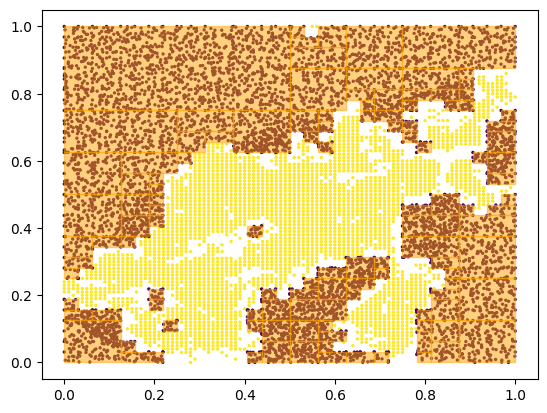

len(task.training_data) =  10137
len(task.testing_data) =  10137
Test Error: 
 Accuracy: 68.3%, Avg loss: 0.950037 

Epoch 949
-------------------------------
Train Error: 
 Accuracy: 66.2%, Avg loss: 0.967536 

Epoch 950
-------------------------------
Train Error: 
 Accuracy: 63.7%, Avg loss: 1.164349 

Epoch 951
-------------------------------
Train Error: 
 Accuracy: 63.9%, Avg loss: 1.143706 

Epoch 952
-------------------------------
Train Error: 
 Accuracy: 63.9%, Avg loss: 1.141215 

Epoch 953
-------------------------------
Train Error: 
 Accuracy: 64.1%, Avg loss: 1.137337 

Epoch 954
-------------------------------
Train Error: 
 Accuracy: 64.1%, Avg loss: 1.134114 

Epoch 955
-------------------------------
Train Error: 
 Accuracy: 64.1%, Avg loss: 1.131239 

Epoch 956
-------------------------------
Train Error: 
 Accuracy: 64.1%, Avg loss: 1.128683 

Epoch 957
-------------------------------
Train Error: 
 Accuracy: 64.1%, Avg loss: 1.126399 

Epoch 958
------------------

Train Error: 
 Accuracy: 64.2%, Avg loss: 1.088749 

Epoch 1035
-------------------------------
Train Error: 
 Accuracy: 64.2%, Avg loss: 1.088508 

Epoch 1036
-------------------------------
Train Error: 
 Accuracy: 64.2%, Avg loss: 1.088268 

Epoch 1037
-------------------------------
Train Error: 
 Accuracy: 64.2%, Avg loss: 1.088030 

Epoch 1038
-------------------------------
Train Error: 
 Accuracy: 64.2%, Avg loss: 1.087793 

Epoch 1039
-------------------------------
Train Error: 
 Accuracy: 64.2%, Avg loss: 1.087556 

Epoch 1040
-------------------------------
Train Error: 
 Accuracy: 64.2%, Avg loss: 1.087321 

Epoch 1041
-------------------------------
Train Error: 
 Accuracy: 64.2%, Avg loss: 1.087087 

Epoch 1042
-------------------------------
Train Error: 
 Accuracy: 64.1%, Avg loss: 1.086854 

Epoch 1043
-------------------------------
Train Error: 
 Accuracy: 64.2%, Avg loss: 1.086622 

Epoch 1044
-------------------------------
Train Error: 
 Accuracy: 64.2%, Avg loss

Train Error: 
 Accuracy: 64.3%, Avg loss: 1.071119 

Epoch 1121
-------------------------------
Train Error: 
 Accuracy: 64.3%, Avg loss: 1.070941 

Epoch 1122
-------------------------------
Train Error: 
 Accuracy: 64.3%, Avg loss: 1.070764 

Epoch 1123
-------------------------------
Train Error: 
 Accuracy: 64.3%, Avg loss: 1.070587 

Epoch 1124
-------------------------------
Train Error: 
 Accuracy: 64.3%, Avg loss: 1.070410 

Epoch 1125
-------------------------------
Train Error: 
 Accuracy: 64.4%, Avg loss: 1.070234 

Epoch 1126
-------------------------------
Train Error: 
 Accuracy: 64.4%, Avg loss: 1.070058 

Epoch 1127
-------------------------------
Train Error: 
 Accuracy: 64.4%, Avg loss: 1.069883 

Epoch 1128
-------------------------------
Train Error: 
 Accuracy: 64.4%, Avg loss: 1.069708 

Epoch 1129
-------------------------------
Train Error: 
 Accuracy: 64.4%, Avg loss: 1.069533 

Epoch 1130
-------------------------------
Train Error: 
 Accuracy: 64.4%, Avg loss

Train Error: 
 Accuracy: 64.7%, Avg loss: 1.056997 

Epoch 1208
-------------------------------
Train Error: 
 Accuracy: 64.7%, Avg loss: 1.056848 

Epoch 1209
-------------------------------
Train Error: 
 Accuracy: 64.7%, Avg loss: 1.056699 

Epoch 1210
-------------------------------
Train Error: 
 Accuracy: 64.7%, Avg loss: 1.056550 

Epoch 1211
-------------------------------
Train Error: 
 Accuracy: 64.7%, Avg loss: 1.056401 

Epoch 1212
-------------------------------
Train Error: 
 Accuracy: 64.7%, Avg loss: 1.056252 

Epoch 1213
-------------------------------
Train Error: 
 Accuracy: 64.7%, Avg loss: 1.056104 

Epoch 1214
-------------------------------
Train Error: 
 Accuracy: 64.7%, Avg loss: 1.055956 

Epoch 1215
-------------------------------
Train Error: 
 Accuracy: 64.7%, Avg loss: 1.055808 

Epoch 1216
-------------------------------
Train Error: 
 Accuracy: 64.7%, Avg loss: 1.055660 

Epoch 1217
-------------------------------
Train Error: 
 Accuracy: 64.7%, Avg loss

Train Error: 
 Accuracy: 65.2%, Avg loss: 1.044733 

Epoch 1295
-------------------------------
Train Error: 
 Accuracy: 65.1%, Avg loss: 1.044599 

Epoch 1296
-------------------------------
Train Error: 
 Accuracy: 65.1%, Avg loss: 1.044466 

Epoch 1297
-------------------------------
Train Error: 
 Accuracy: 65.1%, Avg loss: 1.044332 

Epoch 1298
-------------------------------
Train Error: 
 Accuracy: 65.1%, Avg loss: 1.044199 

Epoch 1299
-------------------------------
Train Error: 
 Accuracy: 65.2%, Avg loss: 1.044066 

Epoch 1300
-------------------------------
Train Error: 
 Accuracy: 65.2%, Avg loss: 1.043934 

Epoch 1301
-------------------------------
Train Error: 
 Accuracy: 65.2%, Avg loss: 1.043801 

Epoch 1302
-------------------------------
Train Error: 
 Accuracy: 65.2%, Avg loss: 1.043669 

Epoch 1303
-------------------------------
Train Error: 
 Accuracy: 65.2%, Avg loss: 1.043536 

Epoch 1304
-------------------------------
Train Error: 
 Accuracy: 65.2%, Avg loss

Train Error: 
 Accuracy: 65.7%, Avg loss: 1.033608 

Epoch 1382
-------------------------------
Train Error: 
 Accuracy: 65.7%, Avg loss: 1.033485 

Epoch 1383
-------------------------------
Train Error: 
 Accuracy: 65.7%, Avg loss: 1.033363 

Epoch 1384
-------------------------------
Train Error: 
 Accuracy: 65.7%, Avg loss: 1.033240 

Epoch 1385
-------------------------------
Train Error: 
 Accuracy: 65.7%, Avg loss: 1.033118 

Epoch 1386
-------------------------------
Train Error: 
 Accuracy: 65.7%, Avg loss: 1.032995 

Epoch 1387
-------------------------------
Train Error: 
 Accuracy: 65.7%, Avg loss: 1.032873 

Epoch 1388
-------------------------------
Train Error: 
 Accuracy: 65.7%, Avg loss: 1.032751 

Epoch 1389
-------------------------------
Train Error: 
 Accuracy: 65.7%, Avg loss: 1.032629 

Epoch 1390
-------------------------------
Train Error: 
 Accuracy: 65.7%, Avg loss: 1.032507 

Epoch 1391
-------------------------------
Train Error: 
 Accuracy: 65.7%, Avg loss

Train Error: 
 Accuracy: 66.0%, Avg loss: 1.023413 

Epoch 1468
-------------------------------
Train Error: 
 Accuracy: 66.0%, Avg loss: 1.023298 

Epoch 1469
-------------------------------
Train Error: 
 Accuracy: 66.0%, Avg loss: 1.023184 

Epoch 1470
-------------------------------
Train Error: 
 Accuracy: 66.0%, Avg loss: 1.023069 

Epoch 1471
-------------------------------
Train Error: 
 Accuracy: 66.0%, Avg loss: 1.022955 

Epoch 1472
-------------------------------
Train Error: 
 Accuracy: 66.1%, Avg loss: 1.022841 

Epoch 1473
-------------------------------
Train Error: 
 Accuracy: 66.1%, Avg loss: 1.022727 

Epoch 1474
-------------------------------
Train Error: 
 Accuracy: 66.1%, Avg loss: 1.022613 

Epoch 1475
-------------------------------
Train Error: 
 Accuracy: 66.1%, Avg loss: 1.022499 

Epoch 1476
-------------------------------
Train Error: 
 Accuracy: 66.1%, Avg loss: 1.022385 

Epoch 1477
-------------------------------
Train Error: 
 Accuracy: 66.1%, Avg loss

Train Error: 
 Accuracy: 66.4%, Avg loss: 1.013737 

Epoch 1555
-------------------------------
Train Error: 
 Accuracy: 66.4%, Avg loss: 1.013629 

Epoch 1556
-------------------------------
Train Error: 
 Accuracy: 66.4%, Avg loss: 1.013521 

Epoch 1557
-------------------------------
Train Error: 
 Accuracy: 66.4%, Avg loss: 1.013414 

Epoch 1558
-------------------------------
Train Error: 
 Accuracy: 66.4%, Avg loss: 1.013306 

Epoch 1559
-------------------------------
Train Error: 
 Accuracy: 66.4%, Avg loss: 1.013198 

Epoch 1560
-------------------------------
Train Error: 
 Accuracy: 66.4%, Avg loss: 1.013091 

Epoch 1561
-------------------------------
Train Error: 
 Accuracy: 66.4%, Avg loss: 1.012983 

Epoch 1562
-------------------------------
Train Error: 
 Accuracy: 66.4%, Avg loss: 1.012876 

Epoch 1563
-------------------------------
Train Error: 
 Accuracy: 66.4%, Avg loss: 1.012768 

Epoch 1564
-------------------------------
Train Error: 
 Accuracy: 66.4%, Avg loss

Train Error: 
 Accuracy: 66.8%, Avg loss: 1.004697 

Epoch 1641
-------------------------------
Train Error: 
 Accuracy: 66.8%, Avg loss: 1.004595 

Epoch 1642
-------------------------------
Train Error: 
 Accuracy: 66.8%, Avg loss: 1.004493 

Epoch 1643
-------------------------------
Train Error: 
 Accuracy: 66.8%, Avg loss: 1.004390 

Epoch 1644
-------------------------------
Train Error: 
 Accuracy: 66.8%, Avg loss: 1.004288 

Epoch 1645
-------------------------------
Train Error: 
 Accuracy: 66.8%, Avg loss: 1.004186 

Epoch 1646
-------------------------------
Train Error: 
 Accuracy: 66.8%, Avg loss: 1.004084 

Epoch 1647
-------------------------------
Train Error: 
 Accuracy: 66.9%, Avg loss: 1.003982 

Epoch 1648
-------------------------------
Train Error: 
 Accuracy: 66.9%, Avg loss: 1.003880 

Epoch 1649
-------------------------------
Train Error: 
 Accuracy: 66.9%, Avg loss: 1.003778 

Epoch 1650
-------------------------------
Train Error: 
 Accuracy: 66.9%, Avg loss

Train Error: 
 Accuracy: 67.2%, Avg loss: 0.996107 

Epoch 1727
-------------------------------
Train Error: 
 Accuracy: 67.3%, Avg loss: 0.996010 

Epoch 1728
-------------------------------
Train Error: 
 Accuracy: 67.3%, Avg loss: 0.995912 

Epoch 1729
-------------------------------
Train Error: 
 Accuracy: 67.3%, Avg loss: 0.995815 

Epoch 1730
-------------------------------
Train Error: 
 Accuracy: 67.3%, Avg loss: 0.995718 

Epoch 1731
-------------------------------
Train Error: 
 Accuracy: 67.3%, Avg loss: 0.995620 

Epoch 1732
-------------------------------
Train Error: 
 Accuracy: 67.3%, Avg loss: 0.995523 

Epoch 1733
-------------------------------
Train Error: 
 Accuracy: 67.3%, Avg loss: 0.995426 

Epoch 1734
-------------------------------
Train Error: 
 Accuracy: 67.3%, Avg loss: 0.995329 

Epoch 1735
-------------------------------
Train Error: 
 Accuracy: 67.3%, Avg loss: 0.995232 

Epoch 1736
-------------------------------
Train Error: 
 Accuracy: 67.3%, Avg loss

Train Error: 
 Accuracy: 67.5%, Avg loss: 0.987821 

Epoch 1814
-------------------------------
Train Error: 
 Accuracy: 67.6%, Avg loss: 0.987728 

Epoch 1815
-------------------------------
Train Error: 
 Accuracy: 67.6%, Avg loss: 0.987635 

Epoch 1816
-------------------------------
Train Error: 
 Accuracy: 67.6%, Avg loss: 0.987542 

Epoch 1817
-------------------------------
Train Error: 
 Accuracy: 67.6%, Avg loss: 0.987449 

Epoch 1818
-------------------------------
Train Error: 
 Accuracy: 67.6%, Avg loss: 0.987356 

Epoch 1819
-------------------------------
Train Error: 
 Accuracy: 67.6%, Avg loss: 0.987263 

Epoch 1820
-------------------------------
Train Error: 
 Accuracy: 67.6%, Avg loss: 0.987170 

Epoch 1821
-------------------------------
Train Error: 
 Accuracy: 67.6%, Avg loss: 0.987078 

Epoch 1822
-------------------------------
Train Error: 
 Accuracy: 67.6%, Avg loss: 0.986985 

Epoch 1823
-------------------------------
Train Error: 
 Accuracy: 67.6%, Avg loss

Train Error: 
 Accuracy: 68.0%, Avg loss: 0.979898 

Epoch 1901
-------------------------------
Train Error: 
 Accuracy: 68.0%, Avg loss: 0.979809 

Epoch 1902
-------------------------------
Train Error: 
 Accuracy: 68.0%, Avg loss: 0.979720 

Epoch 1903
-------------------------------
Train Error: 
 Accuracy: 68.0%, Avg loss: 0.979631 

Epoch 1904
-------------------------------
Train Error: 
 Accuracy: 68.0%, Avg loss: 0.979542 

Epoch 1905
-------------------------------
Train Error: 
 Accuracy: 68.0%, Avg loss: 0.979453 

Epoch 1906
-------------------------------
Train Error: 
 Accuracy: 68.0%, Avg loss: 0.979364 

Epoch 1907
-------------------------------
Train Error: 
 Accuracy: 68.0%, Avg loss: 0.979275 

Epoch 1908
-------------------------------
Train Error: 
 Accuracy: 68.0%, Avg loss: 0.979187 

Epoch 1909
-------------------------------
Train Error: 
 Accuracy: 68.0%, Avg loss: 0.979098 

Epoch 1910
-------------------------------
Train Error: 
 Accuracy: 68.0%, Avg loss

Train Error: 
 Accuracy: 68.2%, Avg loss: 0.972305 

Epoch 1988
-------------------------------
Train Error: 
 Accuracy: 68.2%, Avg loss: 0.972220 

Epoch 1989
-------------------------------
Train Error: 
 Accuracy: 68.2%, Avg loss: 0.972134 

Epoch 1990
-------------------------------
Train Error: 
 Accuracy: 68.2%, Avg loss: 0.972049 

Epoch 1991
-------------------------------
Train Error: 
 Accuracy: 68.2%, Avg loss: 0.971963 

Epoch 1992
-------------------------------
Train Error: 
 Accuracy: 68.2%, Avg loss: 0.971878 

Epoch 1993
-------------------------------
Train Error: 
 Accuracy: 68.2%, Avg loss: 0.971793 

Epoch 1994
-------------------------------
Train Error: 
 Accuracy: 68.2%, Avg loss: 0.971708 

Epoch 1995
-------------------------------
Train Error: 
 Accuracy: 68.2%, Avg loss: 0.971622 

Epoch 1996
-------------------------------
Train Error: 
 Accuracy: 68.2%, Avg loss: 0.971537 

Epoch 1997
-------------------------------
Train Error: 
 Accuracy: 68.3%, Avg loss

Train Error: 
 Accuracy: 68.5%, Avg loss: 0.965013 

Epoch 2075
-------------------------------
Train Error: 
 Accuracy: 68.5%, Avg loss: 0.964931 

Epoch 2076
-------------------------------
Train Error: 
 Accuracy: 68.5%, Avg loss: 0.964849 

Epoch 2077
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss: 0.964767 

Epoch 2078
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss: 0.964685 

Epoch 2079
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss: 0.964603 

Epoch 2080
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss: 0.964521 

Epoch 2081
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss: 0.964439 

Epoch 2082
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss: 0.964357 

Epoch 2083
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss: 0.964275 

Epoch 2084
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss

Train Error: 
 Accuracy: 68.8%, Avg loss: 0.958079 

Epoch 2161
-------------------------------
Train Error: 
 Accuracy: 68.8%, Avg loss: 0.958000 

Epoch 2162
-------------------------------
Train Error: 
 Accuracy: 68.8%, Avg loss: 0.957921 

Epoch 2163
-------------------------------
Train Error: 
 Accuracy: 68.8%, Avg loss: 0.957842 

Epoch 2164
-------------------------------
Train Error: 
 Accuracy: 68.8%, Avg loss: 0.957763 

Epoch 2165
-------------------------------
Train Error: 
 Accuracy: 68.8%, Avg loss: 0.957684 

Epoch 2166
-------------------------------
Train Error: 
 Accuracy: 68.8%, Avg loss: 0.957605 

Epoch 2167
-------------------------------
Train Error: 
 Accuracy: 68.8%, Avg loss: 0.957526 

Epoch 2168
-------------------------------
Train Error: 
 Accuracy: 68.8%, Avg loss: 0.957447 

Epoch 2169
-------------------------------
Train Error: 
 Accuracy: 68.8%, Avg loss: 0.957368 

Epoch 2170
-------------------------------
Train Error: 
 Accuracy: 68.8%, Avg loss

Train Error: 
 Accuracy: 69.0%, Avg loss: 0.951321 

Epoch 2248
-------------------------------
Train Error: 
 Accuracy: 69.0%, Avg loss: 0.951245 

Epoch 2249
-------------------------------
Train Error: 
 Accuracy: 69.0%, Avg loss: 0.951169 

Epoch 2250
-------------------------------
Train Error: 
 Accuracy: 69.0%, Avg loss: 0.951093 

Epoch 2251
-------------------------------
Train Error: 
 Accuracy: 69.0%, Avg loss: 0.951017 

Epoch 2252
-------------------------------
Train Error: 
 Accuracy: 69.0%, Avg loss: 0.950941 

Epoch 2253
-------------------------------
Train Error: 
 Accuracy: 69.0%, Avg loss: 0.950865 

Epoch 2254
-------------------------------
Train Error: 
 Accuracy: 69.0%, Avg loss: 0.950788 

Epoch 2255
-------------------------------
Train Error: 
 Accuracy: 69.0%, Avg loss: 0.950713 

Epoch 2256
-------------------------------
Train Error: 
 Accuracy: 69.0%, Avg loss: 0.950636 

Epoch 2257
-------------------------------
Train Error: 
 Accuracy: 69.0%, Avg loss

Train Error: 
 Accuracy: 69.2%, Avg loss: 0.944805 

Epoch 2335
-------------------------------
Train Error: 
 Accuracy: 69.2%, Avg loss: 0.944732 

Epoch 2336
-------------------------------
Train Error: 
 Accuracy: 69.2%, Avg loss: 0.944658 

Epoch 2337
-------------------------------
Train Error: 
 Accuracy: 69.2%, Avg loss: 0.944585 

Epoch 2338
-------------------------------
Train Error: 
 Accuracy: 69.2%, Avg loss: 0.944511 

Epoch 2339
-------------------------------
Train Error: 
 Accuracy: 69.2%, Avg loss: 0.944438 

Epoch 2340
-------------------------------
Train Error: 
 Accuracy: 69.3%, Avg loss: 0.944364 

Epoch 2341
-------------------------------
Train Error: 
 Accuracy: 69.3%, Avg loss: 0.944291 

Epoch 2342
-------------------------------
Train Error: 
 Accuracy: 69.3%, Avg loss: 0.944218 

Epoch 2343
-------------------------------
Train Error: 
 Accuracy: 69.3%, Avg loss: 0.944144 

Epoch 2344
-------------------------------
Train Error: 
 Accuracy: 69.3%, Avg loss

Train Error: 
 Accuracy: 69.5%, Avg loss: 0.938586 

Epoch 2421
-------------------------------
Train Error: 
 Accuracy: 69.5%, Avg loss: 0.938515 

Epoch 2422
-------------------------------
Train Error: 
 Accuracy: 69.5%, Avg loss: 0.938444 

Epoch 2423
-------------------------------
Train Error: 
 Accuracy: 69.6%, Avg loss: 0.938373 

Epoch 2424
-------------------------------
Train Error: 
 Accuracy: 69.6%, Avg loss: 0.938302 

Epoch 2425
-------------------------------
Train Error: 
 Accuracy: 69.6%, Avg loss: 0.938231 

Epoch 2426
-------------------------------
Train Error: 
 Accuracy: 69.6%, Avg loss: 0.938160 

Epoch 2427
-------------------------------
Train Error: 
 Accuracy: 69.6%, Avg loss: 0.938089 

Epoch 2428
-------------------------------
Train Error: 
 Accuracy: 69.6%, Avg loss: 0.938019 

Epoch 2429
-------------------------------
Train Error: 
 Accuracy: 69.6%, Avg loss: 0.937947 

Epoch 2430
-------------------------------
Train Error: 
 Accuracy: 69.6%, Avg loss

Train Error: 
 Accuracy: 69.8%, Avg loss: 0.932576 

Epoch 2507
-------------------------------
Train Error: 
 Accuracy: 69.8%, Avg loss: 0.932507 

Epoch 2508
-------------------------------
Train Error: 
 Accuracy: 69.8%, Avg loss: 0.932438 

Epoch 2509
-------------------------------
Train Error: 
 Accuracy: 69.8%, Avg loss: 0.932369 

Epoch 2510
-------------------------------
Train Error: 
 Accuracy: 69.9%, Avg loss: 0.932301 

Epoch 2511
-------------------------------
Train Error: 
 Accuracy: 69.9%, Avg loss: 0.932232 

Epoch 2512
-------------------------------
Train Error: 
 Accuracy: 69.9%, Avg loss: 0.932164 

Epoch 2513
-------------------------------
Train Error: 
 Accuracy: 69.9%, Avg loss: 0.932095 

Epoch 2514
-------------------------------
Train Error: 
 Accuracy: 69.9%, Avg loss: 0.932026 

Epoch 2515
-------------------------------
Train Error: 
 Accuracy: 69.9%, Avg loss: 0.931958 

Epoch 2516
-------------------------------
Train Error: 
 Accuracy: 69.9%, Avg loss

Train Error: 
 Accuracy: 70.1%, Avg loss: 0.926695 

Epoch 2594
-------------------------------
Train Error: 
 Accuracy: 70.1%, Avg loss: 0.926629 

Epoch 2595
-------------------------------
Train Error: 
 Accuracy: 70.1%, Avg loss: 0.926562 

Epoch 2596
-------------------------------
Train Error: 
 Accuracy: 70.1%, Avg loss: 0.926496 

Epoch 2597
-------------------------------
Train Error: 
 Accuracy: 70.1%, Avg loss: 0.926430 

Epoch 2598
-------------------------------
Train Error: 
 Accuracy: 70.1%, Avg loss: 0.926363 

Epoch 2599
-------------------------------
Train Error: 
 Accuracy: 70.1%, Avg loss: 0.926297 

Epoch 2600
-------------------------------
Train Error: 
 Accuracy: 70.1%, Avg loss: 0.926231 

Epoch 2601
-------------------------------
Train Error: 
 Accuracy: 70.1%, Avg loss: 0.926164 

Epoch 2602
-------------------------------
Train Error: 
 Accuracy: 70.1%, Avg loss: 0.926098 

Epoch 2603
-------------------------------
Train Error: 
 Accuracy: 70.1%, Avg loss

Train Error: 
 Accuracy: 70.3%, Avg loss: 0.921006 

Epoch 2681
-------------------------------
Train Error: 
 Accuracy: 70.3%, Avg loss: 0.920942 

Epoch 2682
-------------------------------
Train Error: 
 Accuracy: 70.3%, Avg loss: 0.920877 

Epoch 2683
-------------------------------
Train Error: 
 Accuracy: 70.3%, Avg loss: 0.920813 

Epoch 2684
-------------------------------
Train Error: 
 Accuracy: 70.4%, Avg loss: 0.920749 

Epoch 2685
-------------------------------
Train Error: 
 Accuracy: 70.4%, Avg loss: 0.920685 

Epoch 2686
-------------------------------
Train Error: 
 Accuracy: 70.4%, Avg loss: 0.920621 

Epoch 2687
-------------------------------
Train Error: 
 Accuracy: 70.4%, Avg loss: 0.920556 

Epoch 2688
-------------------------------
Train Error: 
 Accuracy: 70.4%, Avg loss: 0.920492 

Epoch 2689
-------------------------------
Train Error: 
 Accuracy: 70.4%, Avg loss: 0.920428 

Epoch 2690
-------------------------------
Train Error: 
 Accuracy: 70.4%, Avg loss

Train Error: 
 Accuracy: 70.6%, Avg loss: 0.915498 

Epoch 2768
-------------------------------
Train Error: 
 Accuracy: 70.6%, Avg loss: 0.915436 

Epoch 2769
-------------------------------
Train Error: 
 Accuracy: 70.6%, Avg loss: 0.915374 

Epoch 2770
-------------------------------
Train Error: 
 Accuracy: 70.6%, Avg loss: 0.915311 

Epoch 2771
-------------------------------
Train Error: 
 Accuracy: 70.6%, Avg loss: 0.915249 

Epoch 2772
-------------------------------
Train Error: 
 Accuracy: 70.6%, Avg loss: 0.915187 

Epoch 2773
-------------------------------
Train Error: 
 Accuracy: 70.6%, Avg loss: 0.915125 

Epoch 2774
-------------------------------
Train Error: 
 Accuracy: 70.7%, Avg loss: 0.915062 

Epoch 2775
-------------------------------
Train Error: 
 Accuracy: 70.7%, Avg loss: 0.915000 

Epoch 2776
-------------------------------
Train Error: 
 Accuracy: 70.7%, Avg loss: 0.914938 

Epoch 2777
-------------------------------
Train Error: 
 Accuracy: 70.7%, Avg loss

Train Error: 
 Accuracy: 71.0%, Avg loss: 0.910162 

Epoch 2855
-------------------------------
Train Error: 
 Accuracy: 71.0%, Avg loss: 0.910102 

Epoch 2856
-------------------------------
Train Error: 
 Accuracy: 71.0%, Avg loss: 0.910041 

Epoch 2857
-------------------------------
Train Error: 
 Accuracy: 71.0%, Avg loss: 0.909981 

Epoch 2858
-------------------------------
Train Error: 
 Accuracy: 71.0%, Avg loss: 0.909921 

Epoch 2859
-------------------------------
Train Error: 
 Accuracy: 71.0%, Avg loss: 0.909860 

Epoch 2860
-------------------------------
Train Error: 
 Accuracy: 71.0%, Avg loss: 0.909800 

Epoch 2861
-------------------------------
Train Error: 
 Accuracy: 71.0%, Avg loss: 0.909740 

Epoch 2862
-------------------------------
Train Error: 
 Accuracy: 71.0%, Avg loss: 0.909680 

Epoch 2863
-------------------------------
Train Error: 
 Accuracy: 71.0%, Avg loss: 0.909620 

Epoch 2864
-------------------------------
Train Error: 
 Accuracy: 71.0%, Avg loss

Train Error: 
 Accuracy: 71.2%, Avg loss: 0.905049 

Epoch 2941
-------------------------------
Train Error: 
 Accuracy: 71.2%, Avg loss: 0.904991 

Epoch 2942
-------------------------------
Train Error: 
 Accuracy: 71.2%, Avg loss: 0.904932 

Epoch 2943
-------------------------------
Train Error: 
 Accuracy: 71.2%, Avg loss: 0.904874 

Epoch 2944
-------------------------------
Train Error: 
 Accuracy: 71.2%, Avg loss: 0.904815 

Epoch 2945
-------------------------------
Train Error: 
 Accuracy: 71.2%, Avg loss: 0.904757 

Epoch 2946
-------------------------------
Train Error: 
 Accuracy: 71.2%, Avg loss: 0.904698 

Epoch 2947
-------------------------------
Train Error: 
 Accuracy: 71.2%, Avg loss: 0.904640 

Epoch 2948
-------------------------------
Train Error: 
 Accuracy: 71.2%, Avg loss: 0.904581 

Epoch 2949
-------------------------------
Train Error: 
 Accuracy: 71.2%, Avg loss: 0.904523 

Epoch 2950
-------------------------------
Train Error: 
 Accuracy: 71.2%, Avg loss

Train Error: 
 Accuracy: 71.4%, Avg loss: 0.900090 

Epoch 3027
-------------------------------
Train Error: 
 Accuracy: 71.4%, Avg loss: 0.900033 

Epoch 3028
-------------------------------
Train Error: 
 Accuracy: 71.4%, Avg loss: 0.899976 

Epoch 3029
-------------------------------
Train Error: 
 Accuracy: 71.4%, Avg loss: 0.899919 

Epoch 3030
-------------------------------
Train Error: 
 Accuracy: 71.4%, Avg loss: 0.899863 

Epoch 3031
-------------------------------
Train Error: 
 Accuracy: 71.4%, Avg loss: 0.899806 

Epoch 3032
-------------------------------
Train Error: 
 Accuracy: 71.4%, Avg loss: 0.899749 

Epoch 3033
-------------------------------
Train Error: 
 Accuracy: 71.4%, Avg loss: 0.899692 

Epoch 3034
-------------------------------
Train Error: 
 Accuracy: 71.4%, Avg loss: 0.899636 

Epoch 3035
-------------------------------
Train Error: 
 Accuracy: 71.5%, Avg loss: 0.899579 

Epoch 3036
-------------------------------
Train Error: 
 Accuracy: 71.5%, Avg loss

Train Error: 
 Accuracy: 71.6%, Avg loss: 0.895221 

Epoch 3114
-------------------------------
Train Error: 
 Accuracy: 71.6%, Avg loss: 0.895166 

Epoch 3115
-------------------------------
Train Error: 
 Accuracy: 71.6%, Avg loss: 0.895111 

Epoch 3116
-------------------------------
Train Error: 
 Accuracy: 71.6%, Avg loss: 0.895056 

Epoch 3117
-------------------------------
Train Error: 
 Accuracy: 71.6%, Avg loss: 0.895001 

Epoch 3118
-------------------------------
Train Error: 
 Accuracy: 71.6%, Avg loss: 0.894946 

Epoch 3119
-------------------------------
Train Error: 
 Accuracy: 71.6%, Avg loss: 0.894891 

Epoch 3120
-------------------------------
Train Error: 
 Accuracy: 71.6%, Avg loss: 0.894836 

Epoch 3121
-------------------------------
Train Error: 
 Accuracy: 71.6%, Avg loss: 0.894781 

Epoch 3122
-------------------------------
Train Error: 
 Accuracy: 71.6%, Avg loss: 0.894726 

Epoch 3123
-------------------------------
Train Error: 
 Accuracy: 71.6%, Avg loss

Train Error: 
 Accuracy: 71.8%, Avg loss: 0.890549 

Epoch 3200
-------------------------------
Train Error: 
 Accuracy: 71.8%, Avg loss: 0.890496 

Epoch 3201
-------------------------------
Train Error: 
 Accuracy: 71.8%, Avg loss: 0.890442 

Epoch 3202
-------------------------------
Train Error: 
 Accuracy: 71.8%, Avg loss: 0.890389 

Epoch 3203
-------------------------------
Train Error: 
 Accuracy: 71.8%, Avg loss: 0.890335 

Epoch 3204
-------------------------------
Train Error: 
 Accuracy: 71.8%, Avg loss: 0.890282 

Epoch 3205
-------------------------------
Train Error: 
 Accuracy: 71.8%, Avg loss: 0.890229 

Epoch 3206
-------------------------------
Train Error: 
 Accuracy: 71.8%, Avg loss: 0.890175 

Epoch 3207
-------------------------------
Train Error: 
 Accuracy: 71.8%, Avg loss: 0.890122 

Epoch 3208
-------------------------------
Train Error: 
 Accuracy: 71.8%, Avg loss: 0.890068 

Epoch 3209
-------------------------------
Train Error: 
 Accuracy: 71.8%, Avg loss

Train Error: 
 Accuracy: 72.0%, Avg loss: 0.885960 

Epoch 3287
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.885908 

Epoch 3288
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.885856 

Epoch 3289
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.885804 

Epoch 3290
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.885752 

Epoch 3291
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.885700 

Epoch 3292
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.885649 

Epoch 3293
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.885597 

Epoch 3294
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.885545 

Epoch 3295
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.885493 

Epoch 3296
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss

Train Error: 
 Accuracy: 72.1%, Avg loss: 0.881554 

Epoch 3373
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.881503 

Epoch 3374
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.881452 

Epoch 3375
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.881402 

Epoch 3376
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.881352 

Epoch 3377
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.881301 

Epoch 3378
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.881251 

Epoch 3379
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.881200 

Epoch 3380
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.881150 

Epoch 3381
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.881100 

Epoch 3382
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss

Train Error: 
 Accuracy: 72.4%, Avg loss: 0.877221 

Epoch 3460
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss: 0.877172 

Epoch 3461
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss: 0.877123 

Epoch 3462
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss: 0.877074 

Epoch 3463
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss: 0.877025 

Epoch 3464
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss: 0.876976 

Epoch 3465
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss: 0.876927 

Epoch 3466
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss: 0.876878 

Epoch 3467
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss: 0.876829 

Epoch 3468
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss: 0.876780 

Epoch 3469
-------------------------------
Train Error: 
 Accuracy: 72.4%, Avg loss

Train Error: 
 Accuracy: 72.5%, Avg loss: 0.873009 

Epoch 3547
-------------------------------
Train Error: 
 Accuracy: 72.5%, Avg loss: 0.872962 

Epoch 3548
-------------------------------
Train Error: 
 Accuracy: 72.5%, Avg loss: 0.872914 

Epoch 3549
-------------------------------
Train Error: 
 Accuracy: 72.5%, Avg loss: 0.872866 

Epoch 3550
-------------------------------
Train Error: 
 Accuracy: 72.5%, Avg loss: 0.872819 

Epoch 3551
-------------------------------
Train Error: 
 Accuracy: 72.5%, Avg loss: 0.872771 

Epoch 3552
-------------------------------
Train Error: 
 Accuracy: 72.5%, Avg loss: 0.872723 

Epoch 3553
-------------------------------
Train Error: 
 Accuracy: 72.5%, Avg loss: 0.872676 

Epoch 3554
-------------------------------
Train Error: 
 Accuracy: 72.5%, Avg loss: 0.872628 

Epoch 3555
-------------------------------
Train Error: 
 Accuracy: 72.5%, Avg loss: 0.872580 

Epoch 3556
-------------------------------
Train Error: 
 Accuracy: 72.5%, Avg loss

Train Error: 
 Accuracy: 72.7%, Avg loss: 0.868869 

Epoch 3635
-------------------------------
Train Error: 
 Accuracy: 72.7%, Avg loss: 0.868823 

Epoch 3636
-------------------------------
Train Error: 
 Accuracy: 72.7%, Avg loss: 0.868776 

Epoch 3637
-------------------------------
Train Error: 
 Accuracy: 72.7%, Avg loss: 0.868730 

Epoch 3638
-------------------------------
Train Error: 
 Accuracy: 72.7%, Avg loss: 0.868683 

Epoch 3639
-------------------------------
Train Error: 
 Accuracy: 72.7%, Avg loss: 0.868637 

Epoch 3640
-------------------------------
Train Error: 
 Accuracy: 72.7%, Avg loss: 0.868591 

Epoch 3641
-------------------------------
Train Error: 
 Accuracy: 72.7%, Avg loss: 0.868544 

Epoch 3642
-------------------------------
Train Error: 
 Accuracy: 72.7%, Avg loss: 0.868498 

Epoch 3643
-------------------------------
Train Error: 
 Accuracy: 72.7%, Avg loss: 0.868452 

Epoch 3644
-------------------------------
Train Error: 
 Accuracy: 72.7%, Avg loss

Train Error: 
 Accuracy: 72.8%, Avg loss: 0.864933 

Epoch 3721
-------------------------------
Train Error: 
 Accuracy: 72.8%, Avg loss: 0.864888 

Epoch 3722
-------------------------------
Train Error: 
 Accuracy: 72.8%, Avg loss: 0.864842 

Epoch 3723
-------------------------------
Train Error: 
 Accuracy: 72.8%, Avg loss: 0.864797 

Epoch 3724
-------------------------------
Train Error: 
 Accuracy: 72.8%, Avg loss: 0.864752 

Epoch 3725
-------------------------------
Train Error: 
 Accuracy: 72.8%, Avg loss: 0.864707 

Epoch 3726
-------------------------------
Train Error: 
 Accuracy: 72.8%, Avg loss: 0.864662 

Epoch 3727
-------------------------------
Train Error: 
 Accuracy: 72.8%, Avg loss: 0.864617 

Epoch 3728
-------------------------------
Train Error: 
 Accuracy: 72.8%, Avg loss: 0.864572 

Epoch 3729
-------------------------------
Train Error: 
 Accuracy: 72.8%, Avg loss: 0.864527 

Epoch 3730
-------------------------------
Train Error: 
 Accuracy: 72.9%, Avg loss

Train Error: 
 Accuracy: 72.9%, Avg loss: 0.861057 

Epoch 3808
-------------------------------
Train Error: 
 Accuracy: 72.9%, Avg loss: 0.861014 

Epoch 3809
-------------------------------
Train Error: 
 Accuracy: 73.0%, Avg loss: 0.860970 

Epoch 3810
-------------------------------
Train Error: 
 Accuracy: 73.0%, Avg loss: 0.860926 

Epoch 3811
-------------------------------
Train Error: 
 Accuracy: 73.0%, Avg loss: 0.860882 

Epoch 3812
-------------------------------
Train Error: 
 Accuracy: 73.0%, Avg loss: 0.860838 

Epoch 3813
-------------------------------
Train Error: 
 Accuracy: 73.0%, Avg loss: 0.860794 

Epoch 3814
-------------------------------
Train Error: 
 Accuracy: 73.0%, Avg loss: 0.860750 

Epoch 3815
-------------------------------
Train Error: 
 Accuracy: 73.0%, Avg loss: 0.860706 

Epoch 3816
-------------------------------
Train Error: 
 Accuracy: 73.0%, Avg loss: 0.860663 

Epoch 3817
-------------------------------
Train Error: 
 Accuracy: 73.0%, Avg loss

Train Error: 
 Accuracy: 73.1%, Avg loss: 0.857287 

Epoch 3895
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.857244 

Epoch 3896
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.857201 

Epoch 3897
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.857158 

Epoch 3898
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.857115 

Epoch 3899
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.857073 

Epoch 3900
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.857030 

Epoch 3901
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.856987 

Epoch 3902
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.856944 

Epoch 3903
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.856902 

Epoch 3904
-------------------------------
Train Error: 
 Accuracy: 73.1%, Avg loss

Train Error: 
 Accuracy: 73.2%, Avg loss: 0.853614 

Epoch 3982
-------------------------------
Train Error: 
 Accuracy: 73.2%, Avg loss: 0.853572 

Epoch 3983
-------------------------------
Train Error: 
 Accuracy: 73.2%, Avg loss: 0.853531 

Epoch 3984
-------------------------------
Train Error: 
 Accuracy: 73.2%, Avg loss: 0.853489 

Epoch 3985
-------------------------------
Train Error: 
 Accuracy: 73.2%, Avg loss: 0.853447 

Epoch 3986
-------------------------------
Train Error: 
 Accuracy: 73.2%, Avg loss: 0.853406 

Epoch 3987
-------------------------------
Train Error: 
 Accuracy: 73.2%, Avg loss: 0.853364 

Epoch 3988
-------------------------------
Train Error: 
 Accuracy: 73.2%, Avg loss: 0.853323 

Epoch 3989
-------------------------------
Train Error: 
 Accuracy: 73.2%, Avg loss: 0.853281 

Epoch 3990
-------------------------------
Train Error: 
 Accuracy: 73.2%, Avg loss: 0.853239 

Epoch 3991
-------------------------------
Train Error: 
 Accuracy: 73.2%, Avg loss

Train Error: 
 Accuracy: 73.3%, Avg loss: 0.850037 

Epoch 4069
-------------------------------
Train Error: 
 Accuracy: 73.3%, Avg loss: 0.849997 

Epoch 4070
-------------------------------
Train Error: 
 Accuracy: 73.3%, Avg loss: 0.849956 

Epoch 4071
-------------------------------
Train Error: 
 Accuracy: 73.3%, Avg loss: 0.849916 

Epoch 4072
-------------------------------
Train Error: 
 Accuracy: 73.3%, Avg loss: 0.849875 

Epoch 4073
-------------------------------
Train Error: 
 Accuracy: 73.4%, Avg loss: 0.849834 

Epoch 4074
-------------------------------
Train Error: 
 Accuracy: 73.4%, Avg loss: 0.849794 

Epoch 4075
-------------------------------
Train Error: 
 Accuracy: 73.4%, Avg loss: 0.849754 

Epoch 4076
-------------------------------
Train Error: 
 Accuracy: 73.4%, Avg loss: 0.849713 

Epoch 4077
-------------------------------
Train Error: 
 Accuracy: 73.4%, Avg loss: 0.849673 

Epoch 4078
-------------------------------
Train Error: 
 Accuracy: 73.4%, Avg loss

Train Error: 
 Accuracy: 73.5%, Avg loss: 0.846552 

Epoch 4156
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.846512 

Epoch 4157
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.846473 

Epoch 4158
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.846433 

Epoch 4159
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.846394 

Epoch 4160
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.846354 

Epoch 4161
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.846315 

Epoch 4162
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.846275 

Epoch 4163
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.846236 

Epoch 4164
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.846196 

Epoch 4165
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss

Train Error: 
 Accuracy: 73.7%, Avg loss: 0.843193 

Epoch 4242
-------------------------------
Train Error: 
 Accuracy: 73.7%, Avg loss: 0.843154 

Epoch 4243
-------------------------------
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.843115 

Epoch 4244
-------------------------------
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.843077 

Epoch 4245
-------------------------------
Train Error: 
 Accuracy: 73.7%, Avg loss: 0.843038 

Epoch 4246
-------------------------------
Train Error: 
 Accuracy: 73.7%, Avg loss: 0.843000 

Epoch 4247
-------------------------------
Train Error: 
 Accuracy: 73.7%, Avg loss: 0.842961 

Epoch 4248
-------------------------------
Train Error: 
 Accuracy: 73.7%, Avg loss: 0.842923 

Epoch 4249
-------------------------------
Train Error: 
 Accuracy: 73.7%, Avg loss: 0.842884 

Epoch 4250
-------------------------------
Train Error: 
 Accuracy: 73.7%, Avg loss: 0.842846 

Epoch 4251
-------------------------------
Train Error: 
 Accuracy: 73.7%, Avg loss

Train Error: 
 Accuracy: 73.8%, Avg loss: 0.839879 

Epoch 4329
-------------------------------
Train Error: 
 Accuracy: 73.8%, Avg loss: 0.839842 

Epoch 4330
-------------------------------
Train Error: 
 Accuracy: 73.8%, Avg loss: 0.839804 

Epoch 4331
-------------------------------
Train Error: 
 Accuracy: 73.8%, Avg loss: 0.839766 

Epoch 4332
-------------------------------
Train Error: 
 Accuracy: 73.8%, Avg loss: 0.839729 

Epoch 4333
-------------------------------
Train Error: 
 Accuracy: 73.8%, Avg loss: 0.839691 

Epoch 4334
-------------------------------
Train Error: 
 Accuracy: 73.8%, Avg loss: 0.839654 

Epoch 4335
-------------------------------
Train Error: 
 Accuracy: 73.8%, Avg loss: 0.839616 

Epoch 4336
-------------------------------
Train Error: 
 Accuracy: 73.8%, Avg loss: 0.839579 

Epoch 4337
-------------------------------
Train Error: 
 Accuracy: 73.8%, Avg loss: 0.839541 

Epoch 4338
-------------------------------
Train Error: 
 Accuracy: 73.8%, Avg loss

Train Error: 
 Accuracy: 73.9%, Avg loss: 0.836684 

Epoch 4415
-------------------------------
Train Error: 
 Accuracy: 73.9%, Avg loss: 0.836648 

Epoch 4416
-------------------------------
Train Error: 
 Accuracy: 73.9%, Avg loss: 0.836611 

Epoch 4417
-------------------------------
Train Error: 
 Accuracy: 73.9%, Avg loss: 0.836574 

Epoch 4418
-------------------------------
Train Error: 
 Accuracy: 73.9%, Avg loss: 0.836538 

Epoch 4419
-------------------------------
Train Error: 
 Accuracy: 73.9%, Avg loss: 0.836501 

Epoch 4420
-------------------------------
Train Error: 
 Accuracy: 73.9%, Avg loss: 0.836465 

Epoch 4421
-------------------------------
Train Error: 
 Accuracy: 73.9%, Avg loss: 0.836428 

Epoch 4422
-------------------------------
Train Error: 
 Accuracy: 73.9%, Avg loss: 0.836391 

Epoch 4423
-------------------------------
Train Error: 
 Accuracy: 73.9%, Avg loss: 0.836354 

Epoch 4424
-------------------------------
Train Error: 
 Accuracy: 73.9%, Avg loss

Train Error: 
 Accuracy: 74.1%, Avg loss: 0.833531 

Epoch 4502
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.833495 

Epoch 4503
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.833459 

Epoch 4504
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.833423 

Epoch 4505
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.833388 

Epoch 4506
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.833352 

Epoch 4507
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.833316 

Epoch 4508
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.833280 

Epoch 4509
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.833245 

Epoch 4510
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.833209 

Epoch 4511
-------------------------------
Train Error: 
 Accuracy: 74.1%, Avg loss

Train Error: 
 Accuracy: 74.2%, Avg loss: 0.830453 

Epoch 4589
-------------------------------
Train Error: 
 Accuracy: 74.2%, Avg loss: 0.830418 

Epoch 4590
-------------------------------
Train Error: 
 Accuracy: 74.2%, Avg loss: 0.830383 

Epoch 4591
-------------------------------
Train Error: 
 Accuracy: 74.2%, Avg loss: 0.830348 

Epoch 4592
-------------------------------
Train Error: 
 Accuracy: 74.2%, Avg loss: 0.830313 

Epoch 4593
-------------------------------
Train Error: 
 Accuracy: 74.2%, Avg loss: 0.830278 

Epoch 4594
-------------------------------
Train Error: 
 Accuracy: 74.2%, Avg loss: 0.830243 

Epoch 4595
-------------------------------
Train Error: 
 Accuracy: 74.2%, Avg loss: 0.830208 

Epoch 4596
-------------------------------
Train Error: 
 Accuracy: 74.2%, Avg loss: 0.830173 

Epoch 4597
-------------------------------
Train Error: 
 Accuracy: 74.2%, Avg loss: 0.830138 

Epoch 4598
-------------------------------
Train Error: 
 Accuracy: 74.2%, Avg loss

Train Error: 
 Accuracy: 74.4%, Avg loss: 0.827413 

Epoch 4677
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.827378 

Epoch 4678
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.827344 

Epoch 4679
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.827310 

Epoch 4680
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.827276 

Epoch 4681
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.827242 

Epoch 4682
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.827208 

Epoch 4683
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.827174 

Epoch 4684
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.827140 

Epoch 4685
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.827106 

Epoch 4686
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss

Train Error: 
 Accuracy: 74.4%, Avg loss: 0.824477 

Epoch 4764
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.824444 

Epoch 4765
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.824411 

Epoch 4766
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.824377 

Epoch 4767
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.824344 

Epoch 4768
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.824311 

Epoch 4769
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.824277 

Epoch 4770
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.824244 

Epoch 4771
-------------------------------
Train Error: 
 Accuracy: 74.5%, Avg loss: 0.824211 

Epoch 4772
-------------------------------
Train Error: 
 Accuracy: 74.5%, Avg loss: 0.824178 

Epoch 4773
-------------------------------
Train Error: 
 Accuracy: 74.5%, Avg loss

Train Error: 
 Accuracy: 74.6%, Avg loss: 0.821610 

Epoch 4851
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.821577 

Epoch 4852
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.821544 

Epoch 4853
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.821512 

Epoch 4854
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.821479 

Epoch 4855
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.821447 

Epoch 4856
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.821414 

Epoch 4857
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.821382 

Epoch 4858
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.821349 

Epoch 4859
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.821317 

Epoch 4860
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss

Train Error: 
 Accuracy: 74.6%, Avg loss: 0.818806 

Epoch 4938
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.818775 

Epoch 4939
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.818743 

Epoch 4940
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.818711 

Epoch 4941
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.818679 

Epoch 4942
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.818647 

Epoch 4943
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.818616 

Epoch 4944
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.818584 

Epoch 4945
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.818552 

Epoch 4946
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss: 0.818520 

Epoch 4947
-------------------------------
Train Error: 
 Accuracy: 74.6%, Avg loss

Train Error: 
 Accuracy: 74.8%, Avg loss: 0.816065 

Epoch 5025
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.816034 

Epoch 5026
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.816003 

Epoch 5027
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.815972 

Epoch 5028
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.815941 

Epoch 5029
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.815909 

Epoch 5030
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.815878 

Epoch 5031
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.815847 

Epoch 5032
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.815816 

Epoch 5033
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss: 0.815785 

Epoch 5034
-------------------------------
Train Error: 
 Accuracy: 74.8%, Avg loss

Train Error: 
 Accuracy: 74.9%, Avg loss: 0.813383 

Epoch 5112
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.813353 

Epoch 5113
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.813322 

Epoch 5114
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.813292 

Epoch 5115
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.813261 

Epoch 5116
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.813231 

Epoch 5117
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.813200 

Epoch 5118
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.813170 

Epoch 5119
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.813139 

Epoch 5120
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.813109 

Epoch 5121
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss

Train Error: 
 Accuracy: 75.0%, Avg loss: 0.810788 

Epoch 5198
-------------------------------
Train Error: 
 Accuracy: 75.0%, Avg loss: 0.810758 

Epoch 5199
-------------------------------
Train Error: 
 Accuracy: 75.0%, Avg loss: 0.810728 

Test Error: 
 Accuracy: 95.8%, Avg loss: 1.516278 

Negative data accuracy: tensor(0.9584)
start verifying
0.0087890625 / 0.015625 = 0.5625
adding counter example, num= 58
0.001953125 / 0.001953125 = 1.0
Verified safe for free_dim_len = 0.51
0 / 0.0009765625 = 0.0
adding counter example, num= 2
0 / 0.0009765625 = 0.0
adding counter example, num= 2
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.001953125 = 0.0
adding counter example, num= 11
0 / 0.0009765625 = 0.0
adding counter example, num= 5
0 / 0.001953125 = 0.0
adding counter example, num= 20
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0 / 0.0009765625 = 0.0
adding counter example, num= 10
0.0009765625 / 0.0009765625 = 1.0
Verified safe for free_dim_len = 0.51
0.0039

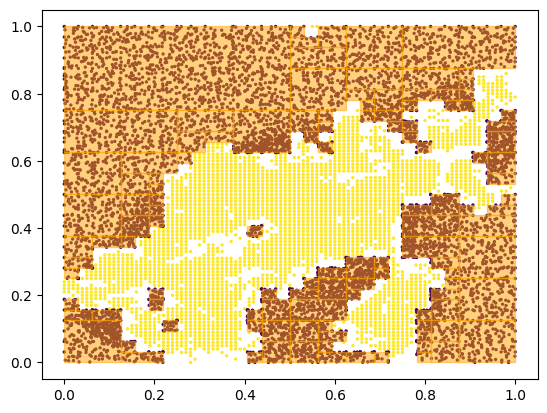

len(task.training_data) =  11105
len(task.testing_data) =  11105
Test Error: 
 Accuracy: 76.6%, Avg loss: 0.800391 

Done!


In [68]:
crime_task = BloomCrimeTask()
accs, losses, verify_steps = train_and_verify(crime_task)

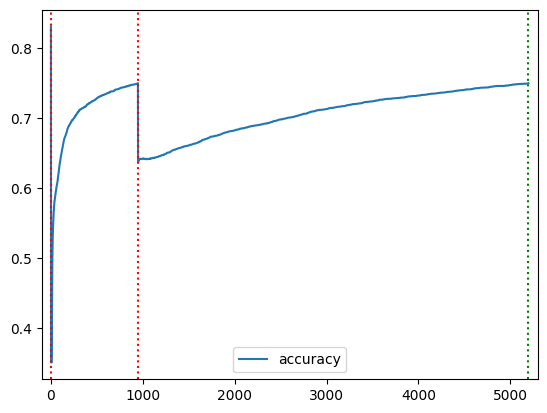

[(0, False), (947, False), (5198, True)]


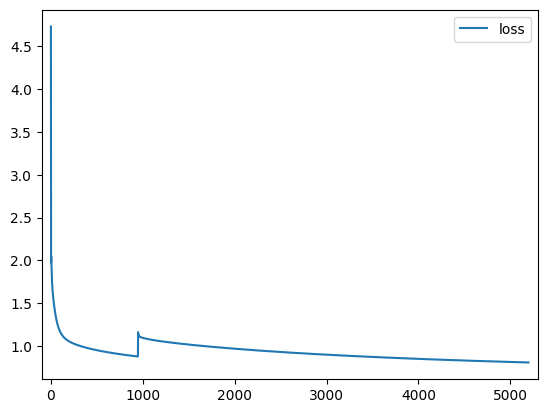

In [79]:
def plot_acc_loss(accs, losses, steps):
    plt.figure()
    plt.plot(accs, label="accuracy")
#     plt.axvline(x = -100, c='g', linestyle=":", label = 'verified safe')
#     plt.axvline(x = -100, c='r', linestyle=":", label = 'found counter examples')
    for t in steps:
        plt.axvline(x=t[0], c='g' if t[1] else 'r', linestyle=":")
    plt.xlim([-100,len(accs)+100])
#     plt.plot(steps, probs, label="verified prob")
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(losses, label="loss")
    
#     plt.axvline(x = -100, c='g', linestyle=":", label = 'verified safe')
#     plt.axvline(x = -100, c='r', linestyle=":", label = 'found counter examples')
#     for t in verify_steps:
#         plt.axvline(x=t[0], c='g' if t[1] else 'r', linestyle=":")
    
    print(steps)
#     plt.plot(steps, probs, label="verified prob")
    plt.xlim([-100,len(accs)+100])
    plt.legend()
    plt.show()
    
    
plot_acc_loss(accs, losses, verify_steps)

Using cpu device
Epoch 1
-------------------------------
Start finetuning.
fc.0.weight   False
fc.0.bias   False
fc.1.weight   True
fc.1.bias   True
Train Error: 
 Accuracy: 83.1%, Avg loss: 4.728132 

Test Error: 
 Accuracy: 100.0%, Avg loss: 2.164739 

Negative data accuracy: tensor(1.)
start verifying
0 / 0.015625 = 0.0
adding counter example, num= 304
0 / 0.001953125 = 0.0
adding counter example, num= 40
0 / 0.0009765625 = 0.0
adding counter example, num= 20
0 / 0.0009765625 = 0.0
adding counter example, num= 20
0 / 0.0009765625 = 0.0
adding counter example, num= 20
0 / 0.001953125 = 0.0
adding counter example, num= 40
0 / 0.0009765625 = 0.0
adding counter example, num= 20
0 / 0.001953125 = 0.0
adding counter example, num= 40
0 / 0.0009765625 = 0.0
adding counter example, num= 20
0 / 0.0009765625 = 0.0
adding counter example, num= 20
0 / 0.0009765625 = 0.0
adding counter example, num= 20
0 / 0.00390625 = 0.0
adding counter example, num= 76
0 / 0.0009765625 = 0.0
adding counter exam

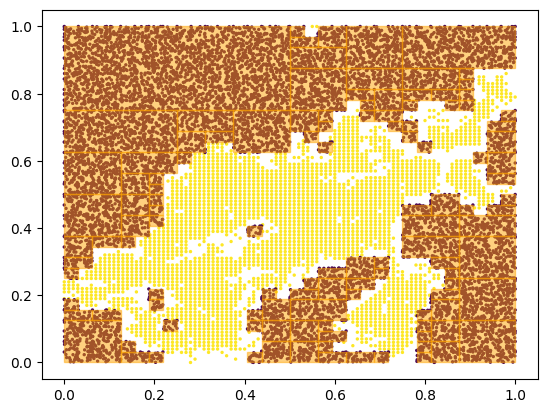

len(task.training_data) =  14332
len(task.testing_data) =  14332
Test Error: 
 Accuracy: 20.8%, Avg loss: 1.871343 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 23.6%, Avg loss: 1.669683 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 30.2%, Avg loss: 1.959102 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 31.6%, Avg loss: 1.966152 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 40.8%, Avg loss: 1.882911 

Epoch 6
-------------------------------
Train Error: 
 Accuracy: 46.5%, Avg loss: 1.823044 

Epoch 7
-------------------------------
Train Error: 
 Accuracy: 49.8%, Avg loss: 1.773130 

Epoch 8
-------------------------------
Train Error: 
 Accuracy: 50.9%, Avg loss: 1.731032 

Epoch 9
-------------------------------
Train Error: 
 Accuracy: 52.1%, Avg loss: 1.694785 

Epoch 10
-------------------------------
Train Error: 
 Accuracy: 53.0%, Avg loss: 1.662972 

Epoch 11
-------------------------------
Trai

Train Error: 
 Accuracy: 67.7%, Avg loss: 1.061920 

Epoch 89
-------------------------------
Train Error: 
 Accuracy: 67.7%, Avg loss: 1.060213 

Epoch 90
-------------------------------
Train Error: 
 Accuracy: 67.8%, Avg loss: 1.058542 

Epoch 91
-------------------------------
Train Error: 
 Accuracy: 67.9%, Avg loss: 1.056906 

Epoch 92
-------------------------------
Train Error: 
 Accuracy: 68.0%, Avg loss: 1.055304 

Epoch 93
-------------------------------
Train Error: 
 Accuracy: 68.1%, Avg loss: 1.053734 

Epoch 94
-------------------------------
Train Error: 
 Accuracy: 68.2%, Avg loss: 1.052196 

Epoch 95
-------------------------------
Train Error: 
 Accuracy: 68.3%, Avg loss: 1.050688 

Epoch 96
-------------------------------
Train Error: 
 Accuracy: 68.4%, Avg loss: 1.049210 

Epoch 97
-------------------------------
Train Error: 
 Accuracy: 68.5%, Avg loss: 1.047759 

Epoch 98
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss: 1.046336 

Epoch 9

Train Error: 
 Accuracy: 72.0%, Avg loss: 0.977977 

Epoch 177
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.977375 

Epoch 178
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.976777 

Epoch 179
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.976183 

Epoch 180
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.975592 

Epoch 181
-------------------------------
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.975004 

Epoch 182
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.974420 

Epoch 183
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.973839 

Epoch 184
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.973261 

Epoch 185
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.972686 

Epoch 186
-------------------------------
Train Error: 
 Accuracy: 72.1%, Avg loss: 0.972115

Train Error: 
 Accuracy: 73.4%, Avg loss: 0.934501 

Epoch 265
-------------------------------
Train Error: 
 Accuracy: 73.4%, Avg loss: 0.934086 

Epoch 266
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.933672 

Epoch 267
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.933260 

Epoch 268
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.932849 

Epoch 269
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.932439 

Epoch 270
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.932031 

Epoch 271
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.931624 

Epoch 272
-------------------------------
Train Error: 
 Accuracy: 73.5%, Avg loss: 0.931218 

Epoch 273
-------------------------------
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.930814 

Epoch 274
-------------------------------
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.930410

Train Error: 
 Accuracy: 74.4%, Avg loss: 0.902306 

Epoch 353
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.901983 

Epoch 354
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.901661 

Epoch 355
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.901339 

Epoch 356
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.901018 

Epoch 357
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.900699 

Epoch 358
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.900380 

Epoch 359
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.900061 

Epoch 360
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.899744 

Epoch 361
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.899427 

Epoch 362
-------------------------------
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.899111

Train Error: 
 Accuracy: 74.9%, Avg loss: 0.876653 

Epoch 441
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.876390 

Epoch 442
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.876128 

Epoch 443
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.875866 

Epoch 444
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.875605 

Epoch 445
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.875345 

Epoch 446
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.875084 

Epoch 447
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.874825 

Epoch 448
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.874566 

Epoch 449
-------------------------------
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.874308 

Epoch 450
-------------------------------
Train Error: 
 Accuracy: 75.0%, Avg loss: 0.874050

0 / 0.0009765625 = 0.0
adding counter example, num= 4
0.001953125 / 0.001953125 = 1.0
Verified safe for free_dim_len = 0.51
0 / 0.0009765625 = 0.0
adding counter example, num= 1
0.001953125 / 0.001953125 = 1.0
Verified safe for free_dim_len = 0.51
0.0078125 / 0.0078125 = 1.0
Verified safe for free_dim_len = 0.51
0 / 0.0009765625 = 0.0
adding counter example, num= 1
0.0009765625 / 0.0009765625 = 1.0
Verified safe for free_dim_len = 0.51
0.0009765625 / 0.0009765625 = 1.0
Verified safe for free_dim_len = 0.51
0.0009765625 / 0.0009765625 = 1.0
Verified safe for free_dim_len = 0.51
0.03125 / 0.03125 = 1.0
Verified safe for free_dim_len = 0.51
Total verified volume:  0.466796875
Total spec volume:      0.578125
verified prob:          0.8074324324324325
checked spec count:  119
unsafe spec count:  55


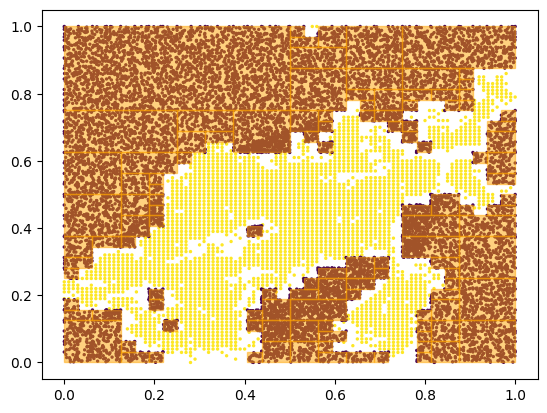

len(task.training_data) =  16170
len(task.testing_data) =  16170
Test Error: 
 Accuracy: 76.2%, Avg loss: 0.938734 

Done!


In [65]:
crime_task = BloomCrimeTask()
accs, losses, verify_steps = train_and_verify(crime_task)

In [ ]:
class ProbToyTask(Task):
    
    def set_learning_params(self):
        self.save_prefix="../models/prob_toy/"
        self.device = "cpu"
        self.epochs = 50
        self.batch_size = 100
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10]))
        
        self.start_finetune_epoch = False
        self.violated_spec_first = False
        self.max_verify_iter = 1000
        self.counter_example_samling_size = 1000
        
        self.prob_hist = []
        
        self.negative_dataloader = DataLoader(self.testing_data, batch_size=1000)
    
    def get_model(self):
        return models.FC(1, 3, 100, 1)
    
    def get_data(self):
        training_data = datasets.ProbToyDataset()
        testing_data = datasets.ProbToyDataset()
        return training_data, testing_data
    
    def get_specs(self):
        
        self.X_specs = []
        self.Y_specs = []
        
        self.X_specs.append(([-1.0, -1.0, -1.0], [1.0, 1.0, 0.0]))
        self.Y_specs.append([np.ones((1,1)), np.zeros(1)])
        
        self.X_specs.append(([-1.0, -1.0, 0.0], [1.0, 1.0, 1.0]))
        self.Y_specs.append([-np.ones((1,1)), np.zeros(1)])
        
        self.free_dim_len = 0.51
        
        return self.X_specs, self.Y_specs, self.free_dim_len            
    
    def training_data_spec_check(self):
        train_dataloader = DataLoader(self.training_data, batch_size=1)
        violation = 0
        for X, y in train_dataloader:
            X = X.detach().cpu().numpy().transpose()
            y = y.detach().cpu().numpy().transpose()
            if self.training_data.y_is_class:
                y = training_data.to_one_hot(y[0])
            for j, (X_spec, Y_spec) in enumerate(zip(self.X_specs, self.Y_specs)):
                if np.all(X_spec[0] < X) and np.all(X < X_spec[1]):
                    if np.any(Y_spec[0] @ y >= Y_spec[1]):
                        violation += 1
        print("training data violation rate = ", violation / len(self.training_data))
        return violation
    
    def check_specs(self, nnet_path):
        all_safe = True
        results = []
        spec_check_list_new = []
        if not self.violated_spec_first:
            self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
        
        self.probs = [[] for i in range(len(self.X_specs))]
        status, counter_examples = None, None
        for j, (X_spec, Y_spec) in enumerate(self.spec_check_list):
            
            print("X_spec")
            print(X_spec)
            print("Y_spec")
            print(Y_spec)
            
            status, verified_prob, counter_examples = Main.prob_verify_Neurify(nnet_path, X_spec, Y_spec, 0.8, max_iter=self.max_verify_iter, sampling_size=self.counter_example_samling_size)
#            status, verified_prob, counter_examples = Main.prob_verify_MIP(nnet_path, X_spec, Y_spec, 0.8, max_iter=self.max_verify_iter, sampling_size=self.counter_example_samling_size)
            print("verified prob: ", verified_prob)
            self.probs[j].append(verified_prob)
            
            results.append(status == "holds")
            if status == "holds":
                print("Verified safe for free_dim_len =", self.free_dim_len)
                results.append(True)
            elif status == "violated":
                print("adding counter example, num=", len(counter_examples))
                for counter_example in counter_examples:
                    gt_y = self.get_label(counter_example)
                    self.training_data.append(counter_example, gt_y)
                    self.testing_data = self.training_data
                spec_check_list_new.append((X_spec, Y_spec))
                results.append(False)
            elif status == "unknown":
                self.max_verify_iter *= 2
                spec_check_list_new.append((X_spec, Y_spec))
                results.append(False)
        
        self.prob_hist.append(self.probs)
        print("checked spec count: ", len(self.spec_check_list))
        print("unsafe spec count: ", len(spec_check_list_new))

        if len(self.spec_check_list) != len(self.X_specs):
            results = results + [False] * (len(self.X_specs) - len(self.spec_check_list))
            
        if self.violated_spec_first:
            if len(spec_check_list_new) == 0:
                self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
            else:
                self.spec_check_list = spec_check_list_new

        return results
    
    def get_label(self, x):
        return np.array([x[2] > 0]).astype('float32')

    def set_spec_free_dim_len(self):
        pass
    
    def start_verify(self, acc, loss):
        acc, loss = test(self.negative_dataloader, self.model, self.loss_fn, self.device, self.acc_cnt_fn)
        return acc > 0.9
    
    def is_finished(self, results, acc):
        if np.all(results):
            return True
        if np.all(results) and acc > 0.95:
            if self.free_dim_len >= 0.5:
                return True
            else:
                self.free_dim_len = min(self.free_dim_len * 2, 0.5)
                self.set_spec_free_dim_len()
        return False
    
    def acc_cnt_fn(self, pred, y):
        return (((pred > 0) != y).sum(axis=-1) == 0).sum()
    
    def set_seed(self):
        torch.manual_seed(0)
    
def prob_toy_run():
    task = ProbToyTask()
    accs, losses, verify_steps = train_and_verify(task)
    return accs, losses, verify_steps

In [77]:
importlib.reload(datasets)
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main
Main.include("verify.jl")

<PyCall.jlwrap sample_counter_examples>

In [78]:
prob_toy_task = ProbToyTask()
accs, losses, verify_steps = train_and_verify(prob_toy_task)

training data violation rate =  0.1301
Using cpu device
Epoch 1
-------------------------------
Start finetuning.
fc.0.weight   False
fc.0.bias   False
fc.1.weight   True
fc.1.bias   True
Train Error: 
 Accuracy: 78.0%, Avg loss: 765.470776 

Test Error: 
 Accuracy: 50.0%, Avg loss: 1.889749 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 51.0%, Avg loss: 308.702515 

Test Error: 
 Accuracy: 50.0%, Avg loss: 1.383091 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 52.0%, Avg loss: 252.668035 

Test Error: 
 Accuracy: 50.0%, Avg loss: 1.157624 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 57.0%, Avg loss: 214.087910 

Test Error: 
 Accuracy: 54.3%, Avg loss: 0.984870 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 64.1%, Avg loss: 183.529094 

Test Error: 
 Accuracy: 62.2%, Avg loss: 0.853540 

Epoch 6
-------------------------------
Train Error: 
 Accuracy: 70.0%, Avg loss: 160.415313 

Test Error: 
 Accuracy

Train Error: 
 Accuracy: 89.0%, Avg loss: 69.424461 

Test Error: 
 Accuracy: 95.4%, Avg loss: 0.191391 

start verifying
X_spec
([-1.0, -1.0, -1.0], [1.0, 1.0, 0.0])
Y_spec
[array([[1.]]), array([0.])]
verified prob:  0.80078125
X_spec
([-1.0, -1.0, 0.0], [1.0, 1.0, 1.0])
Y_spec
[array([[-1.]]), array([0.])]
verified prob:  0.828125
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  22262
len(task.testing_data) =  20000
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.191391 

Epoch 44
-------------------------------
Train Error: 
 Accuracy: 89.1%, Avg loss: 68.611698 

Test Error: 
 Accuracy: 95.4%, Avg loss: 0.189512 

start verifying
X_spec
([-1.0, -1.0, -1.0], [1.0, 1.0, 0.0])
Y_spec
[array([[1.]]), array([0.])]
verified prob:  0.80078125
X_spec
([-1.0, -1.0, 0.0], [1.0, 1.0, 1.0])
Y_spec
[array([[-1.]]), array([0.])]
verified prob:  0.8203125
checked spec count:  2
unsafe spec count:  0
len(task.training_data) =  22262
len(task.testing_data) =  20000
Test Error: 
 

In [79]:
def plot_acc_loss(accs, losses, probs):
    plt.figure()
    plt.plot(accs, label="accuracy")
#     plt.axvline(x = -100, c='g', linestyle=":", label = 'verified safe')
#     plt.axvline(x = -100, c='r', linestyle=":", label = 'found counter examples')
#     for t in verify_steps:
#         plt.axvline(x=t[0], c='g' if t[1] else 'r', linestyle=":")
    plt.xlim([0,len(accs)+1])
    plt.legend()
    plt.plot(probs, label="probs")
    plt.show()
    
    plt.figure()
    plt.plot(losses, label="loss")
    
#     plt.axvline(x = -100, c='g', linestyle=":", label = 'verified safe')
#     plt.axvline(x = -100, c='r', linestyle=":", label = 'found counter examples')
#     for t in verify_steps:
#         plt.axvline(x=t[0], c='g' if t[1] else 'r', linestyle=":")
    plt.xlim([0,len(accs)+1])
    plt.legend()
    plt.show()
    

In [92]:
prob1 = [x[0] for x in prob_toy_task.prob_hist]

In [88]:
len(prob_toy_task.prob_hist)

13

In [95]:
verify_steps

[(37, False),
 (38, False),
 (39, False),
 (40, False),
 (41, False),
 (42, False),
 (43, False),
 (44, False),
 (45, False),
 (46, False),
 (47, False),
 (48, False),
 (49, False)]

In [99]:
len(verify_steps)
steps = [x[0] for x in verify_steps]

<IPython.core.display.Javascript object>


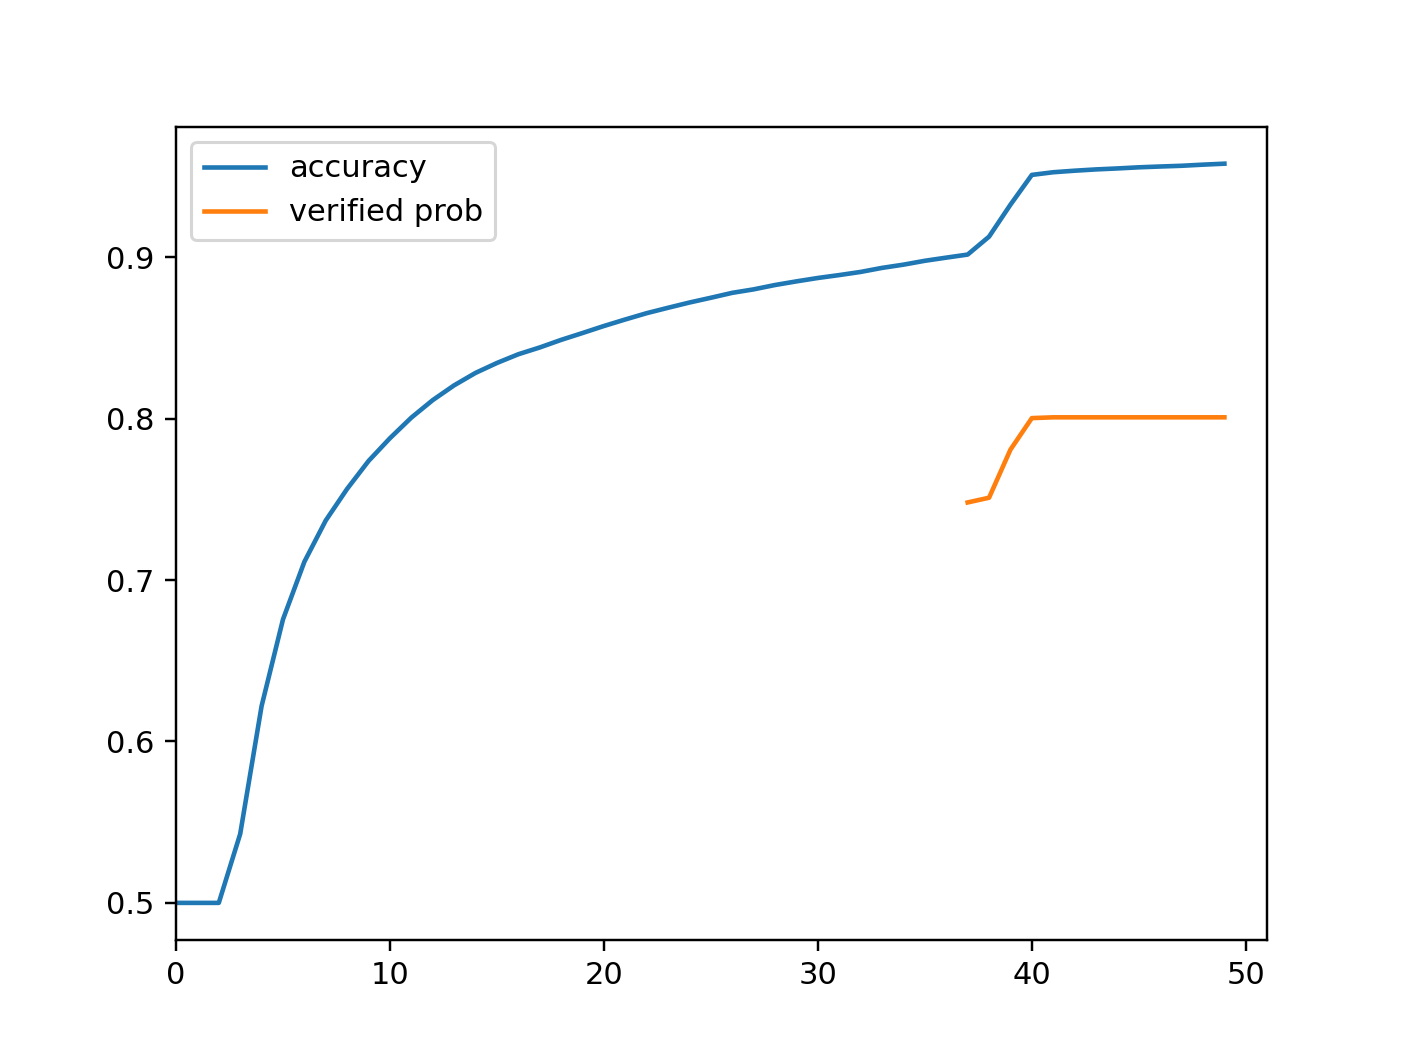

<IPython.core.display.Javascript object>


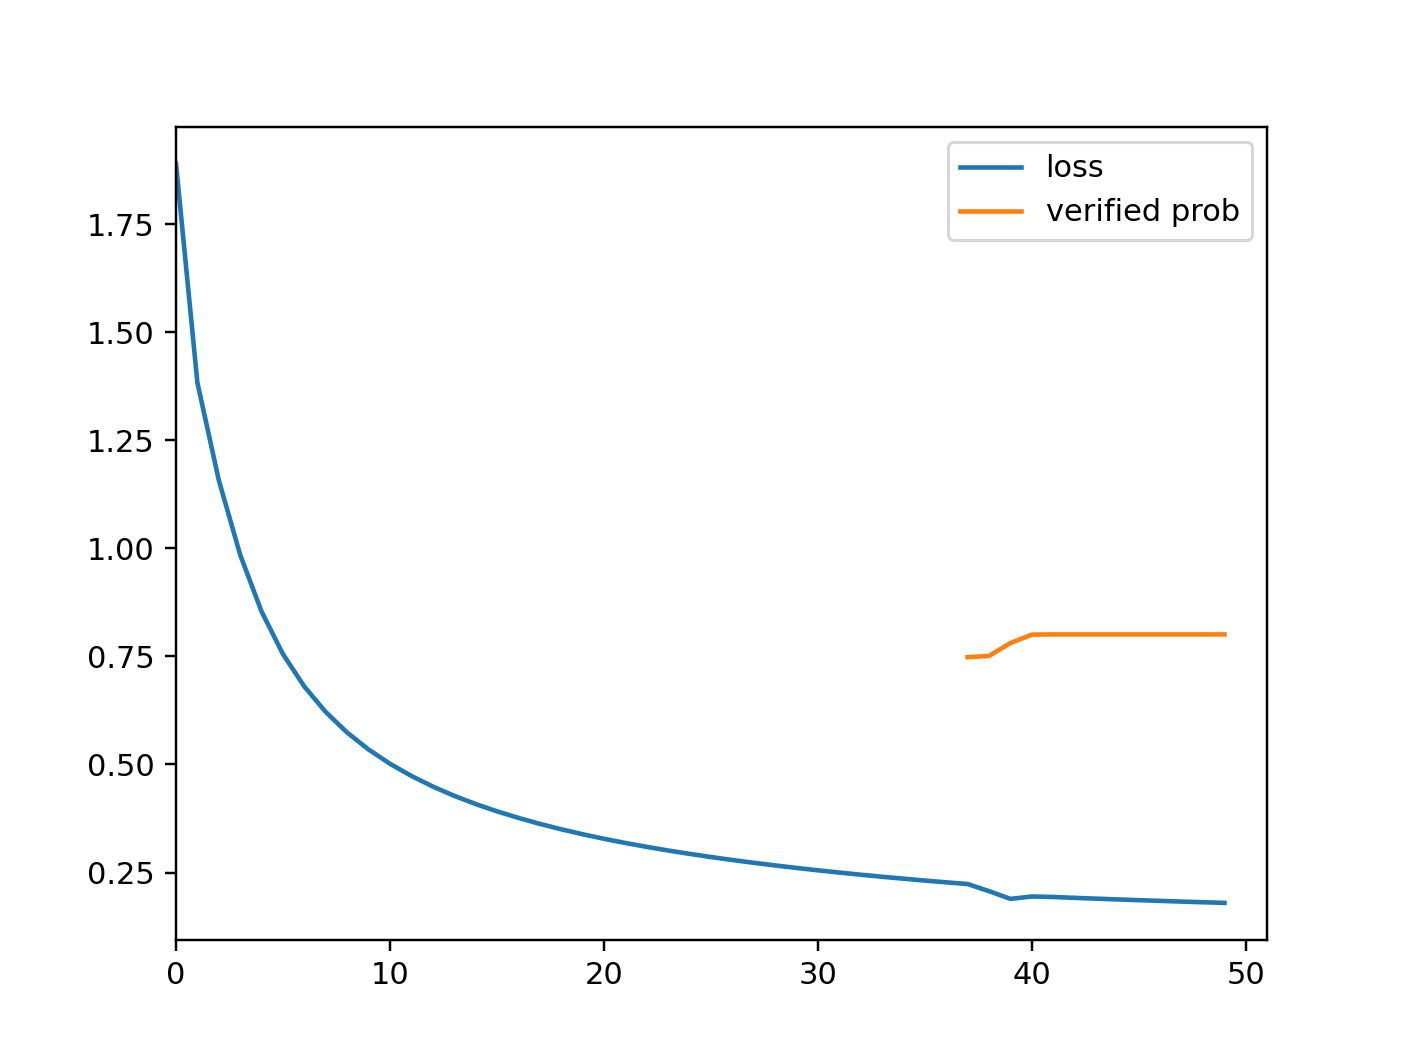

[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [103]:
def plot_acc_loss(accs, losses, steps, probs):
    plt.figure()
    plt.plot(accs, label="accuracy")
#     plt.axvline(x = -100, c='g', linestyle=":", label = 'verified safe')
#     plt.axvline(x = -100, c='r', linestyle=":", label = 'found counter examples')
    for t in steps:
        plt.axvline(x=t[0], c='g' if t[1] else 'r', linestyle=":")
    plt.xlim([0,len(accs)+1])
    plt.plot(steps, probs, label="verified prob")
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(losses, label="loss")
    
#     plt.axvline(x = -100, c='g', linestyle=":", label = 'verified safe')
#     plt.axvline(x = -100, c='r', linestyle=":", label = 'found counter examples')
#     for t in verify_steps:
#         plt.axvline(x=t[0], c='g' if t[1] else 'r', linestyle=":")
    
    print(steps)
    plt.plot(steps, probs, label="verified prob")
    plt.xlim([0,len(accs)+1])
    plt.legend()
    plt.show()
    
    
plot_acc_loss(accs, losses, steps, prob1)

In [58]:
class ProbBloomTask(Task):
    
    def set_learning_params(self):
        self.save_prefix="../models/prob_bloom/"
        self.device = "cpu"
        self.epochs = 1000
        self.batch_size = 100
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10]))
        
        self.start_finetune_epoch = False
        self.violated_spec_first = False
        self.max_verify_iter = 1000
        self.counter_example_samling_size = 2000
        
    def get_model(self):
        return models.FC(1, 7, 1000, 1)
    
    def get_data(self):
        self.n_rules = 1
        training_data = datasets.BloomDataset("../data/bloom/url.csv")
        postive_data = datasets.BloomDataset("../data/bloom/100_positive.csv")
        return training_data, postive_data
    
    def get_specs(self):
        
        self.X_specs = []
        self.Y_specs = []
        
        self.X_specs.append([np.zeros(7), np.ones(7)])
        self.Y_specs.append([np.ones((1,1)), np.zeros(1)])
        
        self.free_dim_len = 0.51
        
        return self.X_specs, self.Y_specs, self.free_dim_len            
    
    def training_data_spec_check(self):
        train_dataloader = DataLoader(self.training_data, batch_size=1)
        violation = 0
        for X, y in train_dataloader:
            X = X.detach().cpu().numpy().transpose()
            y = y.detach().cpu().numpy().transpose()
            if self.training_data.y_is_class:
                y = training_data.to_one_hot(y[0])
            for j, (X_spec, Y_spec) in enumerate(zip(self.X_specs, self.Y_specs)):
                if np.all(X_spec[0] < X) and np.all(X < X_spec[1]):
                    if np.any(Y_spec[0] @ y >= Y_spec[1]):
                        violation += 1
        print("training data violation rate = ", violation / len(self.training_data))
        return violation
    
    def check_specs(self, nnet_path):
        all_safe = True
        results = []
        spec_check_list_new = []
        if not self.violated_spec_first:
            self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
        
        self.probs = [[] for i in range(len(self.X_specs))]
        status, counter_examples = None, None
        for j, (X_spec, Y_spec) in enumerate(self.spec_check_list):
            
            print("X_spec")
            print(X_spec)
            print("Y_spec")
            print(Y_spec)
            
            status, verified_prob, counter_examples = Main.prob_verify_Neurify(nnet_path, X_spec, Y_spec, 0.8, max_iter=self.max_verify_iter, sampling_size=self.counter_example_samling_size)
#            status, verified_prob, counter_examples = Main.prob_verify_MIP(nnet_path, X_spec, Y_spec, 0.8, max_iter=self.max_verify_iter, sampling_size=self.counter_example_samling_size)
            print("verified prob: ", verified_prob)
            self.probs[j].append(verified_prob)
            
            pos_weight = torch.tensor([len(self.training_data) / len(self.testing_data)])
            self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
            
            results.append(status == "holds")
            if status == "holds":
                print("Verified safe for free_dim_len =", self.free_dim_len)
                results.append(True)
            elif status == "violated":
                print("adding counter example, num=", len(counter_examples))
                for counter_example in counter_examples:
                    pred = self.model(torch.from_numpy(counter_example).float().to(self.device))
                    pred_y = np.argmax(pred.detach().cpu().numpy())
                    gt_y = self.get_label(counter_example)
                    self.training_data.append(counter_example, gt_y)
                    self.testing_data = self.training_data
                spec_check_list_new.append((X_spec, Y_spec))
                results.append(False)
            elif status == "unknown":
                self.max_verify_iter *= 2
                spec_check_list_new.append((X_spec, Y_spec))
                results.append(False)

        print("checked spec count: ", len(self.spec_check_list))
        print("unsafe spec count: ", len(spec_check_list_new))

        if len(self.spec_check_list) != len(self.X_specs):
            results = results + [False] * (len(self.X_specs) - len(self.spec_check_list))
            
        if self.violated_spec_first:
            if len(spec_check_list_new) == 0:
                self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
            else:
                self.spec_check_list = spec_check_list_new

        return results
    
    def get_label(self, x):
        return 0

    def set_spec_free_dim_len(self):
        pass
    
    def start_verify(self, acc, loss):
        return acc > 0.5
    
    def acc_cnt_fn(self, pred, y):
        return (((pred > 0) != y).sum(axis=-1) == 0).sum()
    
    def set_seed(self):
        torch.manual_seed(0)
    
def bloom_run():
    task = ProbBloomTask()
    accs, losses, verify_steps = train_and_verify(task)
    return accs, losses, verify_steps

In [59]:
importlib.reload(datasets)

<module 'datasets' from '/home/wth/dev/ouroboros/src/datasets.py'>

In [89]:
bloom_run()

KeyboardInterrupt: 

In [10]:
class ProbPacketTask(Task):
       
    def set_learning_params(self):
        self.save_prefix="../models/prob/"
        self.device = "cpu"
        self.epochs = 1000
        self.batch_size = 100
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.BCEWithLogitsLoss()
        
        self.start_finetune_epoch = False
        self.violated_spec_first = False
        self.max_verify_iter = 1000
        self.counter_example_samling_size = 2000
        
        
    def get_model(self):
#         return models.FC(1, 13, self.n_rules*20, self.n_rules)
        return models.FC(1, 13, 1000, self.n_rules)
    
    def get_data(self):
        self.n_rules = 1
        training_data = datasets.packet_dataset('../data/nnpacket/acl1_1k', '../data/nnpacket/acl1_100_trace', self.n_rules)
        return training_data, training_data
    
    def get_specs(self):
        
        rules = self.training_data.read_rules('../data/nnpacket/acl1_1k')[:self.n_rules]
        self.X_specs = []
        self.Y_specs = []
        m = 13
        
        one_hot = lambda n, i : np.eye(n)[i:i+1]
        
        self.lbs = []
        self.ubs = []
        
        free_dim_len = 0.51
        self.free_dim_len = free_dim_len
        
        for idx, r in enumerate(rules):
            dim_range = self.training_data.rule_to_13_fields(r)
            lb = np.array([x[0] for x in dim_range])
            ub = np.array([x[1] for x in dim_range])
            
            self.lbs.append(lb)
            self.ubs.append(ub)
            
#             self.X_specs.append([np.vstack([-np.eye(m), np.eye(m)]), np.concatenate([-lb, ub])])
#             self.Y_specs.append([-one_hot(self.n_rules, idx), [0.]])
            
            self.X_specs.append([lb, ub])
            self.Y_specs.append([-one_hot(self.n_rules, idx), [0.]])
            
#             for i in range(m):
            for i in range(1):
                
#                 lb_hs = np.concatenate([0.5 + free_dim_len * np.ones(m), -0.5 + free_dim_len * np.ones(m)])
#                 lb_hs[i] = lb[i]
                
#                 ub_hs = np.concatenate([0.5 + free_dim_len * np.ones(m), -0.5 + free_dim_len * np.ones(m)])
#                 ub_hs[m+i] = -ub[i]
                
#                 self.X_specs.append([np.vstack([np.eye(m), -np.eye(m)]), lb_hs])
#                 self.Y_specs.append([one_hot(self.n_rules, idx), [0.]])
#                 self.X_specs.append([np.vstack([np.eye(m), -np.eye(m)]), ub_hs])
#                 self.Y_specs.append([one_hot(self.n_rules, idx), [0.]])
                
                lb_hs = np.concatenate([0.5 - free_dim_len * np.ones(m), 0.5 + free_dim_len * np.ones(m)])
                lb_hs[m+i] = lb[i]
                
                ub_hs = np.concatenate([0.5 - free_dim_len * np.ones(m), 0.5 + free_dim_len * np.ones(m)])
                ub_hs[i] = ub[i]
                
                self.X_specs.append([lb_hs[0:m], lb_hs[m:2*m]])
                self.Y_specs.append([one_hot(self.n_rules, idx), [0.]])

                self.X_specs.append([ub_hs[0:m], ub_hs[m:2*m]])
                self.Y_specs.append([one_hot(self.n_rules, idx), [0.]])
            
        return self.X_specs, self.Y_specs, self.free_dim_len            
    
    def training_data_spec_check(self):
        train_dataloader = DataLoader(self.training_data, batch_size=1)
        violation = 0
        for X, y in train_dataloader:
            X = X.detach().cpu().numpy().transpose()
            y = y.detach().cpu().numpy().transpose()
            if self.training_data.y_is_class:
                y = training_data.to_one_hot(y[0])
            for j, (X_spec, Y_spec) in enumerate(zip(self.X_specs, self.Y_specs)):
                if np.all(X_spec[0] < X) and np.all(X < X_spec[1]):
                    if np.any(Y_spec[0] @ y >= Y_spec[1]):
                        violation += 1
        print("training data violation rate = ", violation / len(self.training_data))
        return violation

    
    def check_specs(self, nnet_path):
        all_safe = True
        results = []
        spec_check_list_new = []
        if not self.violated_spec_first:
            self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
        
        self.probs = [[] for i in range(len(self.X_specs))]
        status, counter_examples = None, None
        for j, (X_spec, Y_spec) in enumerate(self.spec_check_list):
            
            if j == 0:
#             if True:
#             if False:
                status, counter_examples = Main.verify(nnet_path, X_spec, Y_spec, max_iter=self.max_verify_iter, sampling_size=self.counter_example_samling_size)
            else:
                status, verified_prob, counter_examples = Main.prob_verify_Neurify(nnet_path, X_spec, Y_spec, 0.8, max_iter=self.max_verify_iter, sampling_size=self.counter_example_samling_size)
#                 status, verified_prob, counter_examples = Main.prob_verify_MIP(nnet_path, X_spec, Y_spec, 0.8, max_iter=self.max_verify_iter, sampling_size=self.counter_example_samling_size)
                print("verified prob: ", verified_prob)
                self.probs[j].append(verified_prob)
            
#             print(X_spec)
#             print(len(counter_examples))
#             print(np.shape(counter_examples[0]))
#             print(counter_examples[0])
#             print("verify result = ", status)
            results.append(status == "holds")
            if status == "holds":
                print("Verified safe for free_dim_len =", self.free_dim_len)
                results.append(True)
            elif status == "violated":
                print("adding counter example, num=", len(counter_examples))
                for counter_example in counter_examples:
                    pred = self.model(torch.from_numpy(counter_example).float().to(self.device))
                    pred_y = np.argmax(pred.detach().cpu().numpy())
                    gt_y = self.get_label(counter_example)
                    self.training_data.append(counter_example, gt_y)
                    self.testing_data = self.training_data
                spec_check_list_new.append((X_spec, Y_spec))
                results.append(False)
            elif status == "unknown":
                self.max_verify_iter *= 2
                spec_check_list_new.append((X_spec, Y_spec))
                results.append(False)

        print("checked spec count: ", len(self.spec_check_list))
        print("unsafe spec count: ", len(spec_check_list_new))

        if len(self.spec_check_list) != len(self.X_specs):
            results = results + [False] * (len(self.X_specs) - len(self.spec_check_list))
            
        if self.violated_spec_first:
            if len(spec_check_list_new) == 0:
                self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
            else:
                self.spec_check_list = spec_check_list_new

        return results
    
    def get_label(self, x):
        label = np.zeros(self.n_rules)
        for i in range(self.n_rules):
            label[i] = np.all(self.lbs[i] <= x) & np.all(x <= self.ubs[i])
        return label

    def set_spec_free_dim_len(self):
        m = 13
        for i in range(self.n_rules):
            for j in range(m):
                self.X_specs[i*(1+m*2)+1+j*2+0][1][1] = -self.free_dim_len
                self.X_specs[i*(1+m*2)+1+j*2+1][1][0] =  self.free_dim_len
    
    def start_verify(self, acc, loss):
        return acc > 0.5
    
    def acc_cnt_fn(self, pred, y):
        return (((pred > 0) != y).sum(axis=-1) == 0).sum()
    
    def set_seed(self):
        torch.manual_seed(0)
    
    
def prob_run():
    task = ProbPacketTask()
    accs, losses, verify_steps, training_data = train_and_verify(task)
    return accs, losses, verify_steps

In [112]:
Main.include("verify.jl")

<PyCall.jlwrap sample_counter_examples>

In [ ]:
# probtask = ProbPacketTask()
# prob_accs, prob_losses, prob_verify_steps, _ = train_and_verify(probtask)

training data violation rate =  0.027083793942073844
Using cpu device
Epoch 1
-------------------------------
Start finetuning.
fc.0.weight   False
fc.0.bias   False
fc.1.weight   True
fc.1.bias   True
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.043996 

start verifying
adding counter example, num= 2000
verified prob:  0.9375
verified prob:  1.0
checked spec count:  3
unsafe spec count:  1
len(task.training_data) =  11046
len(task.test_data) =  11046
Test Error: 
 Accuracy: 81.3%, Avg loss: 0.763918 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 18.7%, Avg loss: 1.122053 

Epoch 3
-------------------------------


In [55]:
class ProbTask(Task):
       
    def set_learning_params(self):
        self.save_prefix="../models/prob/"
        self.device = "cpu"
        self.epochs = 10000
        self.batch_size = 100
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.BCEWithLogitsLoss()
        
        self.start_finetune_epoch = False
        self.violated_spec_first = False
        self.max_verify_iter = 300
        self.counter_example_samling_size = 1000
        
        
    def get_model(self):
        return models.FC(1, 3, 20, 1)
    
    def get_data(self):
        training_data = datasets.prob_dataset()
        return training_data, training_data
    
    def get_specs(self):
        
        self.X_specs = []
        self.Y_specs = []
        
        one_hot = lambda n, i : np.eye(n)[i:i+1]
        
        free_dim_len = 0.51
        self.free_dim_len = free_dim_len
        
        self.X_specs.append(([0.,0.,0.], [0.2,1.,1.]))
        self.Y_specs.append((-np.eye(1),[0.]))
        self.X_specs.append(([0.2,0.,0.], [1.,1.,1.]))
        self.Y_specs.append((np.eye(1),[0.]))
        
        return self.X_specs, self.Y_specs, self.free_dim_len            
    
    def training_data_spec_check(self):
        train_dataloader = DataLoader(self.training_data, batch_size=1)
        violation = 0
        for X, y in train_dataloader:
            X = X.detach().cpu().numpy().transpose()
            y = y.detach().cpu().numpy().transpose()
            if self.training_data.y_is_class:
                y = training_data.to_one_hot(y[0])
            for j, (X_spec, Y_spec) in enumerate(zip(self.X_specs, self.Y_specs)):
                if np.all(X_spec[0] < X) and np.all(X < X_spec[1]):
                    if np.any(Y_spec[0] @ y >= Y_spec[1]):
                        violation += 1
        print("training data violation rate = ", violation / len(self.training_data))
        return violation

    
    def check_specs(self, nnet_path):
        all_safe = True
        results = []
        spec_check_list_new = []
        if not self.violated_spec_first:
            self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
        
        self.probs = [[] for i in range(len(self.X_specs))]
        status, counter_examples = None, None
        self.counter_example_samling_size = max(self.counter_example_samling_size, len(self.training_data)//10)
        for j, (X_spec, Y_spec) in enumerate(self.spec_check_list):
            
#             if j == 0:
#             if True:
            if False:
                status, counter_examples = Main.verify(nnet_path, X_spec, Y_spec, max_iter=self.max_verify_iter, sampling_size=self.counter_example_samling_size)
            else:
                status, verified_prob, counter_examples = Main.prob_verify_Neurify(nnet_path, X_spec, Y_spec, 0.8, max_iter=self.max_verify_iter, sampling_size=self.counter_example_samling_size)
#                 status, verified_prob, counter_examples = Main.prob_verify_MIP(nnet_path, X_spec, Y_spec, 0.8, max_iter=self.max_verify_iter, sampling_size=self.counter_example_samling_size)
                print("verified prob: ", verified_prob)
                self.probs[j].append(verified_prob)
            
#             print(X_spec)
#             print(len(counter_examples))
#             print(np.shape(counter_examples[0]))
#             print(counter_examples[0])
#             print("verify result = ", status)
            results.append(status == "holds")
            if status == "holds":
                print("Verified safe for free_dim_len =", self.free_dim_len)
                results.append(True)
            elif status == "violated":
                print("adding counter example, num=", len(counter_examples))
                for k, counter_example in enumerate(counter_examples):
                    pred = self.model(torch.from_numpy(counter_example).float().to(self.device))
                    pred_y = np.argmax(pred.detach().cpu().numpy())
                    gt_y = self.get_label(counter_example)
                    self.training_data.append(counter_example, gt_y)
                    self.testing_data = self.training_data
                spec_check_list_new.append((X_spec, Y_spec))
                results.append(False)
            elif status == "unknown":
                self.max_verify_iter *= 2
                spec_check_list_new.append((X_spec, Y_spec))
                results.append(False)

        print("checked spec count: ", len(self.spec_check_list))
        print("unsafe spec count: ", len(spec_check_list_new))

        if len(self.spec_check_list) != len(self.X_specs):
            results = results + [False] * (len(self.X_specs) - len(self.spec_check_list))
            
        if self.violated_spec_first:
            if len(spec_check_list_new) == 0:
                self.spec_check_list = list(zip(self.X_specs, self.Y_specs))
            else:
                self.spec_check_list = spec_check_list_new

        return results
    
    def get_label(self, x):
        return self.training_data.get_label(x)

    def set_spec_free_dim_len(self):
        pass
        
    def start_verify(self, acc, loss):
        return acc > 0.5
    
    def acc_cnt_fn(self, pred, y):
        return (((pred > 0) != y).sum(axis=-1) == 0).sum()
    
    def set_seed(self):
        torch.manual_seed(0)
        
    
    def is_finished(self, results, acc):
        if np.all(results) and acc > 0.8:
            if self.free_dim_len >= 0.5:
                return True
            else:
                self.free_dim_len = min(self.free_dim_len * 2, 0.5)
                self.set_spec_free_dim_len()
        return False
    
def prob_run():
    task = ProbTask()
    accs, losses, verify_steps, training_data = train_and_verify(task)
    return accs, losses, verify_steps


In [56]:
importlib.reload(datasets)
Main.include("verify.jl")

<PyCall.jlwrap sample_counter_examples>

In [57]:
prob_task = ProbTask()
accs, losses, verify_steps = train_and_verify(prob_task)

training data violation rate =  0.522
Using cpu device
Epoch 1
-------------------------------
Start finetuning.
fc.0.weight   False
fc.0.bias   False
fc.1.weight   True
fc.1.bias   True
Train Error: 
 Accuracy: 37.0%, Avg loss: 7.081469 

Test Error: 
 Accuracy: 42.3%, Avg loss: 0.699810 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 47.8%, Avg loss: 6.927585 

Test Error: 
 Accuracy: 55.6%, Avg loss: 0.684825 

start verifying
verified prob:  0.8124999999999997
verified prob:  0.3144531249999998
adding counter example, num= 586
checked spec count:  2
unsafe spec count:  1
len(task.training_data) =  1586
len(task.testing_data) =  1586
Test Error: 
 Accuracy: 38.8%, Avg loss: 0.695721 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 62.4%, Avg loss: 10.913647 

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.669283 

start verifying
verified prob:  0.5351562500000002
adding counter example, num= 578
verified prob:  0.7509765625000006
adding counter exam

KeyboardInterrupt: 

In [ ]:
def plot_acc_loss(accs, losses, verify_steps):
    plt.figure()
    plt.plot(accs, label="accuracy")
    plt.axvline(x = -100, c='g', linestyle=":", label = 'verified safe')
    plt.axvline(x = -100, c='r', linestyle=":", label = 'found counter examples')
    for t in verify_steps:
        plt.axvline(x=t[0], c='g' if t[1] else 'r', linestyle=":")
    plt.xlim([0,len(accs)+1])
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(losses, label="loss")
    plt.axvline(x = -100, c='g', linestyle=":", label = 'verified safe')
    plt.axvline(x = -100, c='r', linestyle=":", label = 'found counter examples')
    for t in verify_steps:
        plt.axvline(x=t[0], c='g' if t[1] else 'r', linestyle=":")
    plt.xlim([0,len(accs)+1])
    plt.legend()
    plt.show()

In [25]:

def plot_acc_loss(accs, losses, probs):
    plt.figure()
    plt.plot(accs, label="accuracy")
#     plt.axvline(x = -100, c='g', linestyle=":", label = 'verified safe')
#     plt.axvline(x = -100, c='r', linestyle=":", label = 'found counter examples')
#     for t in verify_steps:
#         plt.axvline(x=t[0], c='g' if t[1] else 'r', linestyle=":")
    plt.xlim([0,len(accs)+1])
    plt.legend()
    plt.plot(probs, label="probs")
    plt.show()
    
    plt.figure()
    plt.plot(losses, label="loss")
    
#     plt.axvline(x = -100, c='g', linestyle=":", label = 'verified safe')
#     plt.axvline(x = -100, c='r', linestyle=":", label = 'found counter examples')
#     for t in verify_steps:
#         plt.axvline(x=t[0], c='g' if t[1] else 'r', linestyle=":")
    plt.xlim([0,len(accs)+1])
    plt.legend()
    plt.show()
    

In [27]:
prob_task.probs

[[0.8124999999999996], [0.8027343750000002]]

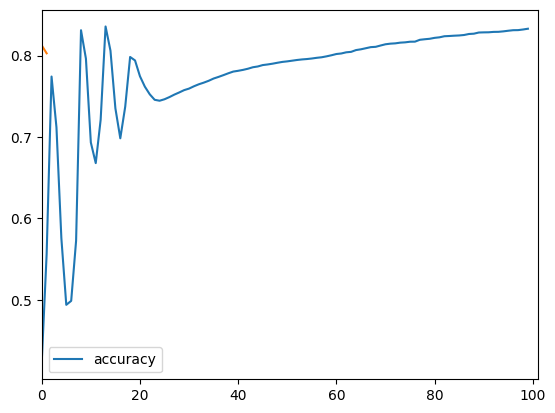

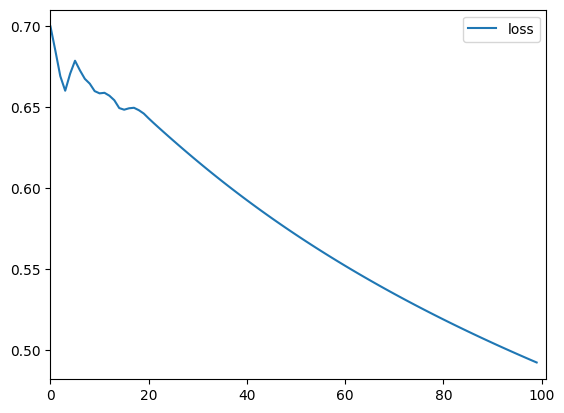

In [26]:
plot_acc_loss(accs, losses, prob_task.probs)

In [12]:
class PacketTask(Task):
       
    def set_learning_params(self):
        self.save_prefix="../models/packet/"
        self.device = "cpu"
        self.epochs = 1000
        self.batch_size = 100
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.BCEWithLogitsLoss()
        
        self.start_finetune_epoch = 50
        self.violated_spec_first = False
        self.max_verify_iter = 100
        self.counter_example_samling_size = 2000
        
        
    def get_model(self):
        return models.FC(1, 13, self.n_rules*100, self.n_rules)
    
    def get_data(self):
        self.n_rules = 3
        training_data = datasets.packet_dataset('../data/nnpacket/acl1_1k', '../data/nnpacket/acl1_100_trace', self.n_rules)
        return training_data, training_data
    
    def get_specs(self):
        
        rules = self.training_data.read_rules('../data/nnpacket/acl1_1k')[:self.n_rules]
        self.X_specs = []
        self.Y_specs = []
        m = 13
        
        one_hot = lambda n, i : np.eye(n)[i:i+1]
        
        self.lbs = []
        self.ubs = []
        
        free_dim_len = 0.51
        self.free_dim_len = free_dim_len
        
        for idx, r in enumerate(rules):
            dim_range = self.training_data.rule_to_13_fields(r)
            lb = np.array([x[0] for x in dim_range])
            ub = np.array([x[1] for x in dim_range])
            
            self.lbs.append(lb)
            self.ubs.append(ub)
            
            self.X_specs.append([np.vstack([-np.eye(m), np.eye(m)]), np.concatenate([-lb, ub])])
            self.Y_specs.append([-one_hot(self.n_rules, idx), [0.]])
            
            for i in range(m):
                
                lb_hs = np.concatenate([0.5 + free_dim_len * np.ones(m), -0.5 + free_dim_len * np.ones(m)])
                lb_hs[i] = lb[i]
                
                ub_hs = np.concatenate([0.5 + free_dim_len * np.ones(m), -0.5 + free_dim_len * np.ones(m)])
                ub_hs[m+i] = -ub[i]
                
                self.X_specs.append([np.vstack([np.eye(m), -np.eye(m)]), lb_hs])
                self.Y_specs.append([one_hot(self.n_rules, idx), [0.]])

                self.X_specs.append([np.vstack([np.eye(m), -np.eye(m)]), ub_hs])
                self.Y_specs.append([one_hot(self.n_rules, idx), [0.]])
        
        return self.X_specs, self.Y_specs, self.free_dim_len            
    
    def get_label(self, x):
        label = np.zeros(self.n_rules)
        for i in range(self.n_rules):
            label[i] = np.all(self.lbs[i] <= x) & np.all(x <= self.ubs[i])
        return label

    def set_spec_free_dim_len(self):
        m = 13
        for i in range(self.n_rules):
            for j in range(m):
                self.X_specs[i*(1+m*2)+1+j*2+0][1][1] = -self.free_dim_len
                self.X_specs[i*(1+m*2)+1+j*2+1][1][0] =  self.free_dim_len
    
    def acc_cnt_fn(self, pred, y):
        return (((pred > 0) != y).sum(axis=-1) == 0).sum()

def packet_run():
    task = PacketTask()
    accs, losses, verify_steps, training_data = train_and_verify(task)
    return accs, losses, verify_steps

In [17]:
packet_accs, packet_losses, packet_verify_steps = packet_run()

training data violation rate =  0.0
Using cpu device
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.051193 

start verifying
verify result =  violated
adding counter example, num= 2000
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_d

verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  violated
adding counter example, num= 2000
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Verified safe for free_dim_len = 0.51
verify result =  holds
Ve

KeyboardInterrupt: 

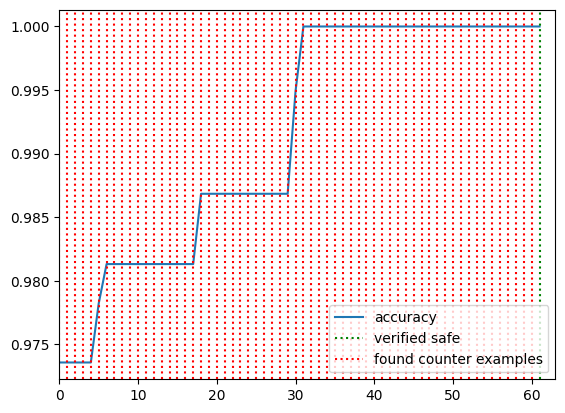

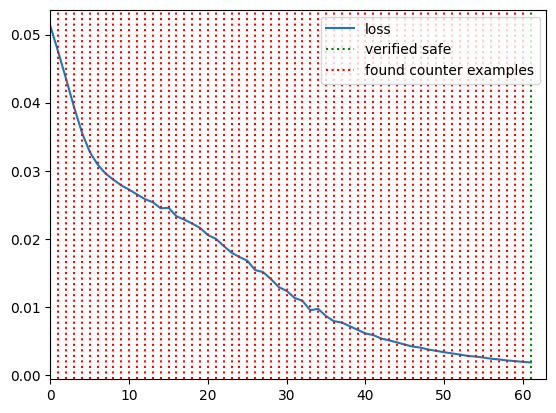

In [173]:
plot_acc_loss(packet_accs, packet_losses, packet_verify_steps)

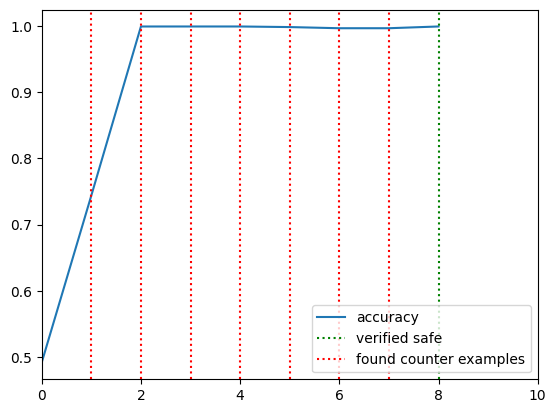

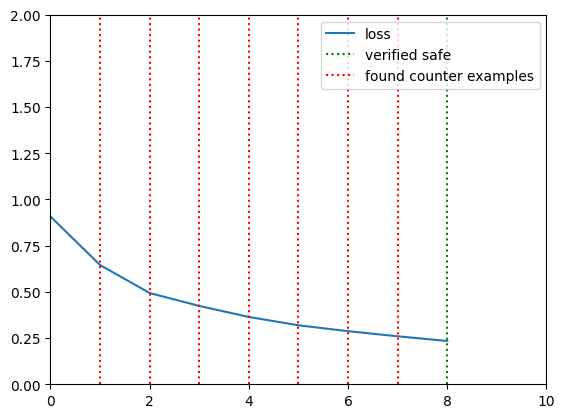

In [71]:
plot_acc_loss(toy_accs, toy_losses, toy_verify_steps)

In [141]:


class RedisTask(Task):
       
    def set_learning_params(self):
        self.save_prefix="../models/redis/"
        self.device = "cpu"
        self.epochs = 1000
        self.batch_size = 1000
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.start_finetune_epoch = -1
        self.violated_spec_first = False
        self.max_verify_iter = 100
        self.counter_example_samling_size = 100
        
    def get_model(self):
        return models.FC(2, 16, 300, 4)
    
    def get_data(self):
        normalize=True
        lifetime_class_bounds = [5000, 10000, 100000, Inf]
        data_path = '../data/redis/data_encoded.txt'
        training_data = datasets.allocator_dataset(data_path, lifetime_class_bounds, normalize=normalize, sampling_ratio=0.05)
        return training_data, training_data
    
    def get_specs(self, normalize=False):
        data = self.training_data
        x_center = np.array([data.shift[0]/2, 3, 24, 50, 40, 30, 31, 2, 0, 0, 0, 0, 0, 0, 0, 0] - data.shift)/data.scale
        eps = 1e-6
        
        free_dim_len = 0.1
        x_len = np.array([free_dim_len, eps, eps, eps, eps, eps, eps, eps, eps, eps, eps, eps, eps, eps, eps, eps])
        y_classes = [0]
        X_spec = (np.vstack([np.eye(16), -np.eye(16)]), np.hstack([x_center+x_len, -x_center+x_len]))
        Y_spec = [np.zeros((data.num_class-1,data.num_class)).astype(np.float), np.zeros(data.num_class-1).astype(np.float)]
        np.fill_diagonal(Y_spec[0], 1)
        Y_spec[0][:,y_classes[0]] = -1.
        Y_spec[0][y_classes[0],data.num_class-1] = 1.

        return [X_spec], [Y_spec], free_dim_len
    
    def get_label(self, x):
        return 0

    def set_spec_free_dim_len(self):
        self.X_specs[0][1][0] = self.free_dim_len
    
    def start_verify(self, acc, loss):
        return acc > 0.5
    
    def is_finished(self, results, acc):
        if np.all(results) and acc > 0.8:
            if self.free_dim_len >= 0.5:
                return True
            else:
                self.free_dim_len = min(self.free_dim_len * 2, 0.5)
                self.set_spec_free_dim_len()
        return False
    
def redis():
    task = RedisTask()
    accs, losses, verify_steps = train_and_verify(task)
    return accs, losses, verify_steps
    
#     print("len(training_data)")
#     print(len(training_data))
#     print("training data, scale, shift")
#     print(training_data.scale, training_data.shift)

    
#     accs, losses, verify_steps, training_data = train_and_verify(training_data, model, X_specs, Y_specs, y_classes, redis_set_spec_free_dim_len, batch_size=1000, counter_example_samling_size=1000)
#     return accs, losses, verify_steps, training_data
    

In [142]:
redis_accs, redis_losses, redis_verify_steps = redis()

training data violation rate =  0.0
Using cpu device
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 48.4%, Avg loss: 0.844112 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 82.6%, Avg loss: 0.594808 

start verifying
verify result =  holds
Verified safe for free_dim_len = 0.1
checked spec count:  1
unsafe spec count:  0
Test Error: 
 Accuracy: 82.6%, Avg loss: 0.594808 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 82.6%, Avg loss: 0.520747 

start verifying
verify result =  holds
Verified safe for free_dim_len = 0.2
checked spec count:  1
unsafe spec count:  0
Test Error: 
 Accuracy: 82.6%, Avg loss: 0.520747 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.494451 

start verifying
verify result =  holds
Verified safe for free_dim_len = 0.4
checked spec count:  1
unsafe spec count:  0
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.494451 

Epoch 5
-------------------------------
Test Error: 
 Accura

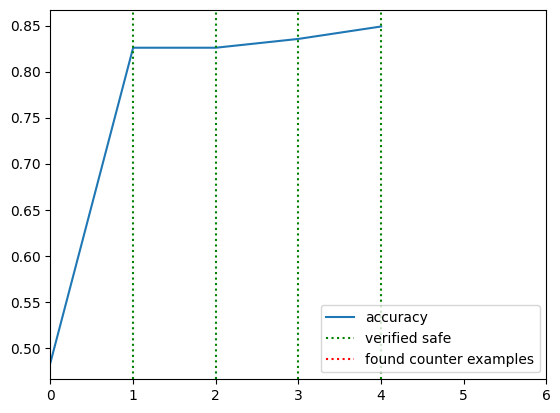

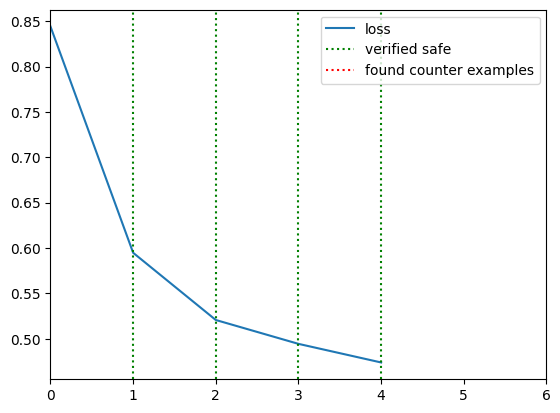

In [143]:
plot_acc_loss(redis_accs, redis_losses, redis_verify_steps)

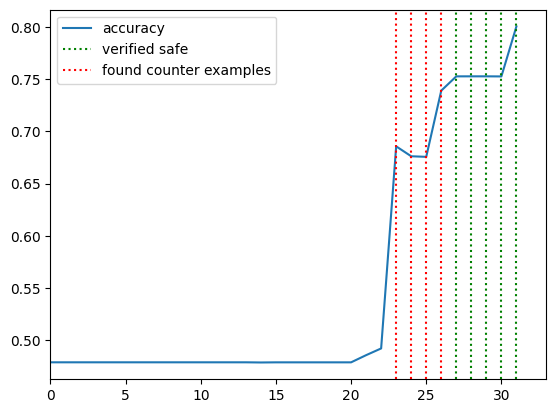

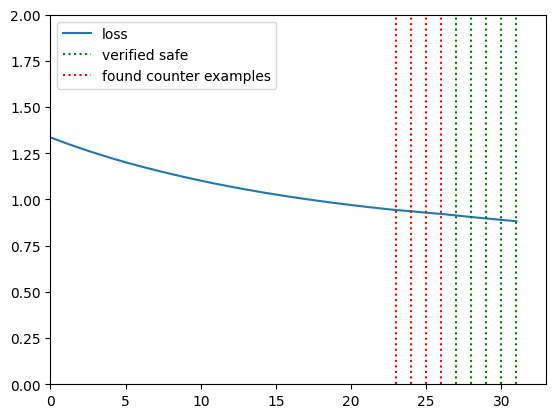

In [31]:
plot_acc_loss(redis_accs, redis_losses, redis_verify_steps)

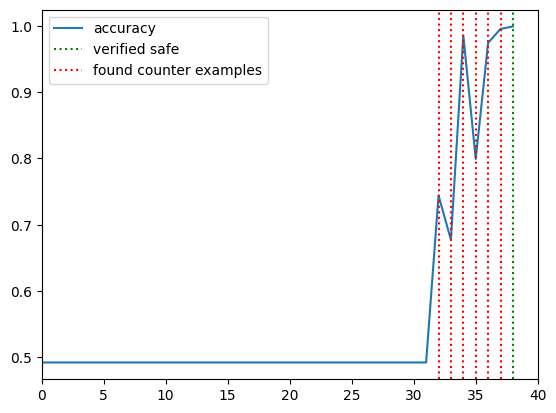

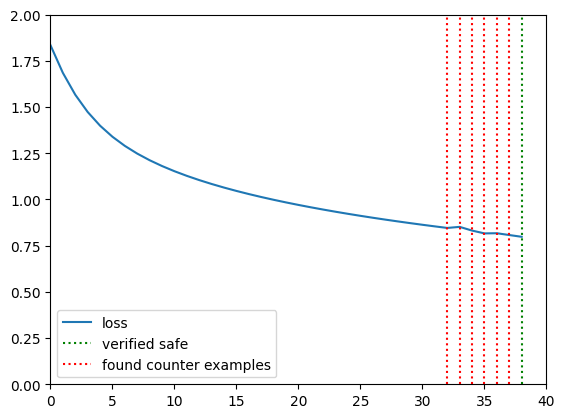

In [36]:
plot_acc_loss(toy_accs, toy_losses, toy_verify_steps)